# Car Commute Interventions and Analysis


This analysis uses the 2018 Transportation survey.

View the survey instrument: https://static1.squarespace.com/static/5b63672bcef372eea958d8a5/t/5c059d9c4fa51ac0d9435219/1543871900238/Commuting-2018-Survey.pdf


Goals:

Estimate metrics  for the community and interventions.
Metrics
- car commuters and parking demand
- CO2 emissions from car commutes

Baseline data is modified with interventions.

Part of the work to  compute estimates is to first create the baseline, based on travel  survey results.

Analysis is done by computing metrics across `(type) x (distance from MIT)`

Interventions are applied to `(type) x (distance from MIT)` and outcomes are recomputed.


To model entire community, first restrict survey to respondents who answered necessary questions:
- Q61: In the last year, have you driven to campus for work or study?
    - Answering YES to this is required in order for people to be asked  whether they use MIT parking facilities  -- which is data we need
- 'week_1', ...'week_5' in response to the question "Please indicate how you commuted TO CAMPUS each day LAST WEEK."


##### total daily MIT car commuters:
estimated with responses weighted by the number of days per week respondents in each group drive.

##### total daily distance driven by MIT car commuters:
summation over each partition: [2 x (car commuter weight) x driving distance)

multiplication by 2 is to account for both commute directions.

##### total daily CO2 emissions from MIT car commuters:
According to the EPA: The average passenger vehicle emits about 404 grams of CO2 per mile https://www.epa.gov/greenvehicles/greenhouse-gas-emissions-typical-passenger-vehicle

(avg CO2 emissions) x (total daily distance driven by MIT car commuters)


In [1]:
%config Completer.use_jedi = False # autocomplete

from datetime import timedelta, date

import geopandas as gpd
import numpy as np
import pandas as pd
import scipy.stats as stats
from tabulate import tabulate # for printing out tabular results

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


GEOID = 'GEOID' # blockgroup

SURVEY18_FILEPATH =  '../data/private/transportation_survey/2018TR.csv'
SURVEY18_CODEBOOK_FILEPATH = '../data/private/transportation_survey/2018TR_Codebook.xlsx'

Plotting consistences: group order and colors

In [2]:
group_order = ['Administrative Staff', 'Service Staff', 'Support Staff',
       'Sponsored Research Staff', 'Other Academic Group', 'Faculty',
       'Graduate Student', 'Undergraduate Student']
c_car_commuters = [c/256 for c in (108,108,108)]
c_non_car_commuters = [c/256 for c in (179,179,179)]

## Use parking transactions data to check estimates

The transportation survey was sent out to students October 22 2018. Observe the number of MIT parking users in weekdays during that period.

In [3]:
MIT_ID = 'MIT_ID'
ENTRY_DATE = 'ENTRY_DATE'
EXIT_DATE = 'EXIT_DATE'
ACTIVITY_TYPE = 'ACTIVITY_TYPE'

parking_transactions_fpath = '../data/private/parking_transactions.csv'
parking_df = pd.read_csv(parking_transactions_fpath)[
    [ENTRY_DATE, EXIT_DATE, ACTIVITY_TYPE, MIT_ID]
]

/Users/aberke/projects/CS_MITOS/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (2,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
TRANSACTION_DATE = 'TRANSACTION_DATE'
def transaction_date(row): 
    return row[EXIT_DATE] if row[ACTIVITY_TYPE]=='X' else row[ENTRY_DATE]
parking_df[TRANSACTION_DATE] = parking_df.apply(transaction_date, axis=1)

parking_df = parking_df.sort_values(TRANSACTION_DATE)
print('Earliest transaction data:', parking_df.iloc[0][TRANSACTION_DATE])
print('Last transaction data:', parking_df.iloc[-1][TRANSACTION_DATE])

Earliest transaction data: 2018-09-14
Last transaction data: 2020-03-11


In [5]:
def get_parking_users(d, parking_df=parking_df):
    """Returns the number of unique parking users on date d."""
    return parking_df[parking_df[TRANSACTION_DATE]==d][MIT_ID].nunique()

Make a table with the day and number of unique parking users for the  weekdays of October.

Exclude Columbus day: 2018-10-08.

In [957]:
dates = []
weekdays = []
parking_users = []

start_date = date(2018, 10, 1)
end_date = date(2018, 10, 31)

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield (start_date + timedelta(n))

        
for d in daterange(start_date, end_date):
    weekday = d.isoweekday()
    if weekday in range(1, 6):
        dates += [d.strftime("%Y-%m-%d")]
        weekdays += [weekday]
        parking_users += [get_parking_users(d.strftime("%Y-%m-%d"))]
        
oct_parking = pd.DataFrame({
    'date': dates,
    'weekday': weekdays,
    'parking users': parking_users,
})
# delete columbus day
oct_parking = oct_parking[oct_parking['date']!='2018-10-08']

In [958]:
oct_parking.describe()

weekday  parking users
count  21.000000      21.000000
mean    2.952381    2236.476190
std     1.430950     146.779297
min     1.000000    1881.000000
25%     2.000000    2230.000000
50%     3.000000    2282.000000
75%     4.000000    2333.000000
max     5.000000    2406.000000

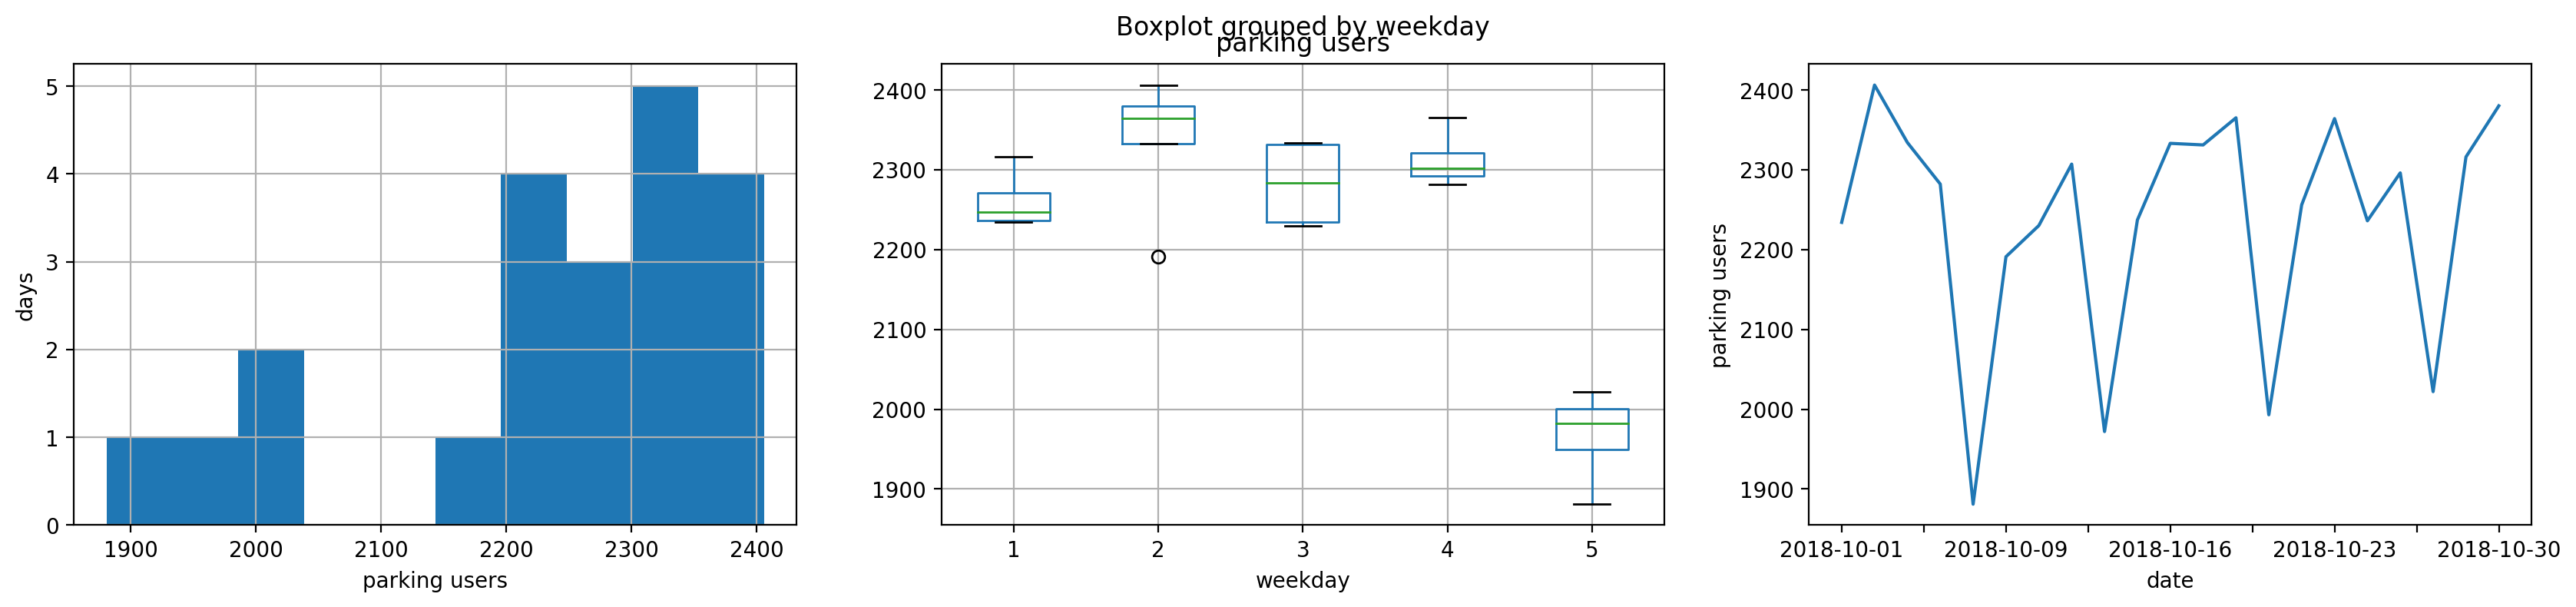

date  weekday  parking users
0   2018-10-01        1           2234
1   2018-10-02        2           2406
2   2018-10-03        3           2334
3   2018-10-04        4           2282
4   2018-10-05        5           1881
6   2018-10-09        2           2191
7   2018-10-10        3           2230
8   2018-10-11        4           2307
9   2018-10-12        5           1972
10  2018-10-15        1           2237
11  2018-10-16        2           2333
12  2018-10-17        3           2331
13  2018-10-18        4           2365
14  2018-10-19        5           1993
15  2018-10-22        1           2256
16  2018-10-23        2           2364
17  2018-10-24        3           2236
18  2018-10-25        4           2296
19  2018-10-26        5           2022
20  2018-10-29        1           2316
21  2018-10-30        2           2380

In [980]:
fig,ax = plt.subplots(1,3, figsize=(20,4), dpi=100)

oct_parking['parking users'].hist(bins=10,ax=ax[0])
ax[0].set_xlabel('parking users')
ax[0].set_ylabel('days')
oct_parking.boxplot(column='parking users', by='weekday', ax=ax[1])
oct_parking.set_index('date')['parking users'].plot(ax=ax[2])
_= ax[2].set_ylabel('parking users')
plt.show()
oct_parking

## Load in the codebook that describes the transportation survey data

In [118]:
survey18_codebook = pd.read_excel(SURVEY18_CODEBOOK_FILEPATH, header=1).set_index('Variable')
print('codebook columns:',list(survey18_codebook.columns))
survey18_codebook[['Label','Measurement Level']].head()

codebook columns: ['Position', 'Label', 'Measurement Level', 'Role', 'Column Width', 'Alignment', 'Print Format', 'Write Format']


Label Measurement Level
Variable                                                                   
Year                             Year survey administered             Scale
ExternalDataReference               ExternalDataReference           Nominal
PID                    Unique ID (same for 2016 and 2018)           Nominal
ANSWER                                    Answered Survey           Nominal
TYPE_NUM                                             Type           Nominal

In [6]:
survey18_df = pd.read_csv(SURVEY18_FILEPATH,
                         dtype={'E_Age':'str',
                                GEOID: 'str'}, # for easier merging  with shapefile
                          na_values=' ')
assert(survey18_df['Year'].unique() == [2018])
columns = list(survey18_df.columns)
print('%s columns'%len(columns))

142 columns


/Users/aberke/projects/CS_MITOS/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (10,41,72,73,74,75,76,79,80,81,86,92,93,94,95,96,98,99,100,101,106) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
survey18_df.columns

Index(['Year', 'ExternalDataReference', 'PID', 'ANSWER', 'TYPE_NUM',
       'OffCampus', 'BenefitsEligible', 'GEOID', 'Gender', 'E_Age',
       ...
       'applyparking', 'bikemone_1', 'bikemone_2', 'bikemone_3', 'bikemone_4',
       'bikemone_5', 'bikemone_6', 'bikemone_7', 'bikemone_8', 'bikemone_9'],
      dtype='object', length=142)

### Shapefile
Load in the shapefile(s) and merge geographic information with survey information.

COUNTYFP TRACTCE  distance to MIT (miles)  \
GEOID                                                    
250277304011      027  730401                35.421511   
250277304014      027  730401                35.034617   

              driving distance to MIT (miles)  \
GEOID                                           
250277304011                        40.303552   
250277304014                        39.689265   

                                                       geometry  
GEOID                                                            
250277304011  POLYGON ((-71.78563 42.30372, -71.78547 42.303...  
250277304014  POLYGON ((-71.77701 42.30069, -71.77698 42.300...

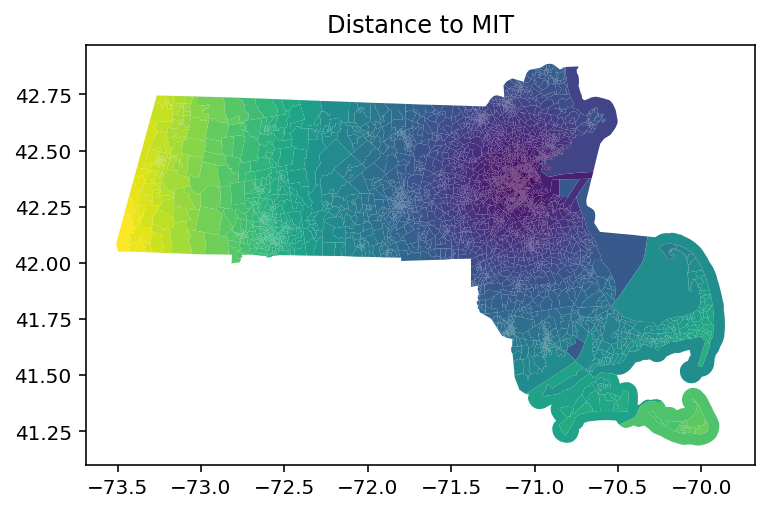

In [64]:
bg_shapes_filepath = '../data/public/shapes_25_bg'
bg = gpd.read_file(bg_shapes_filepath).set_index('GEOID')
bg.columns = [
    'COUNTYFP',
    'TRACTCE',
    'distance to MIT (miles)',
    'driving distance to MIT (miles)',
    'geometry']
bg.plot(column='distance to MIT (miles)')
plt.title('Distance to MIT')
bg.head(2)

line max:  5.997935794154404
drive max:  8.6494221829


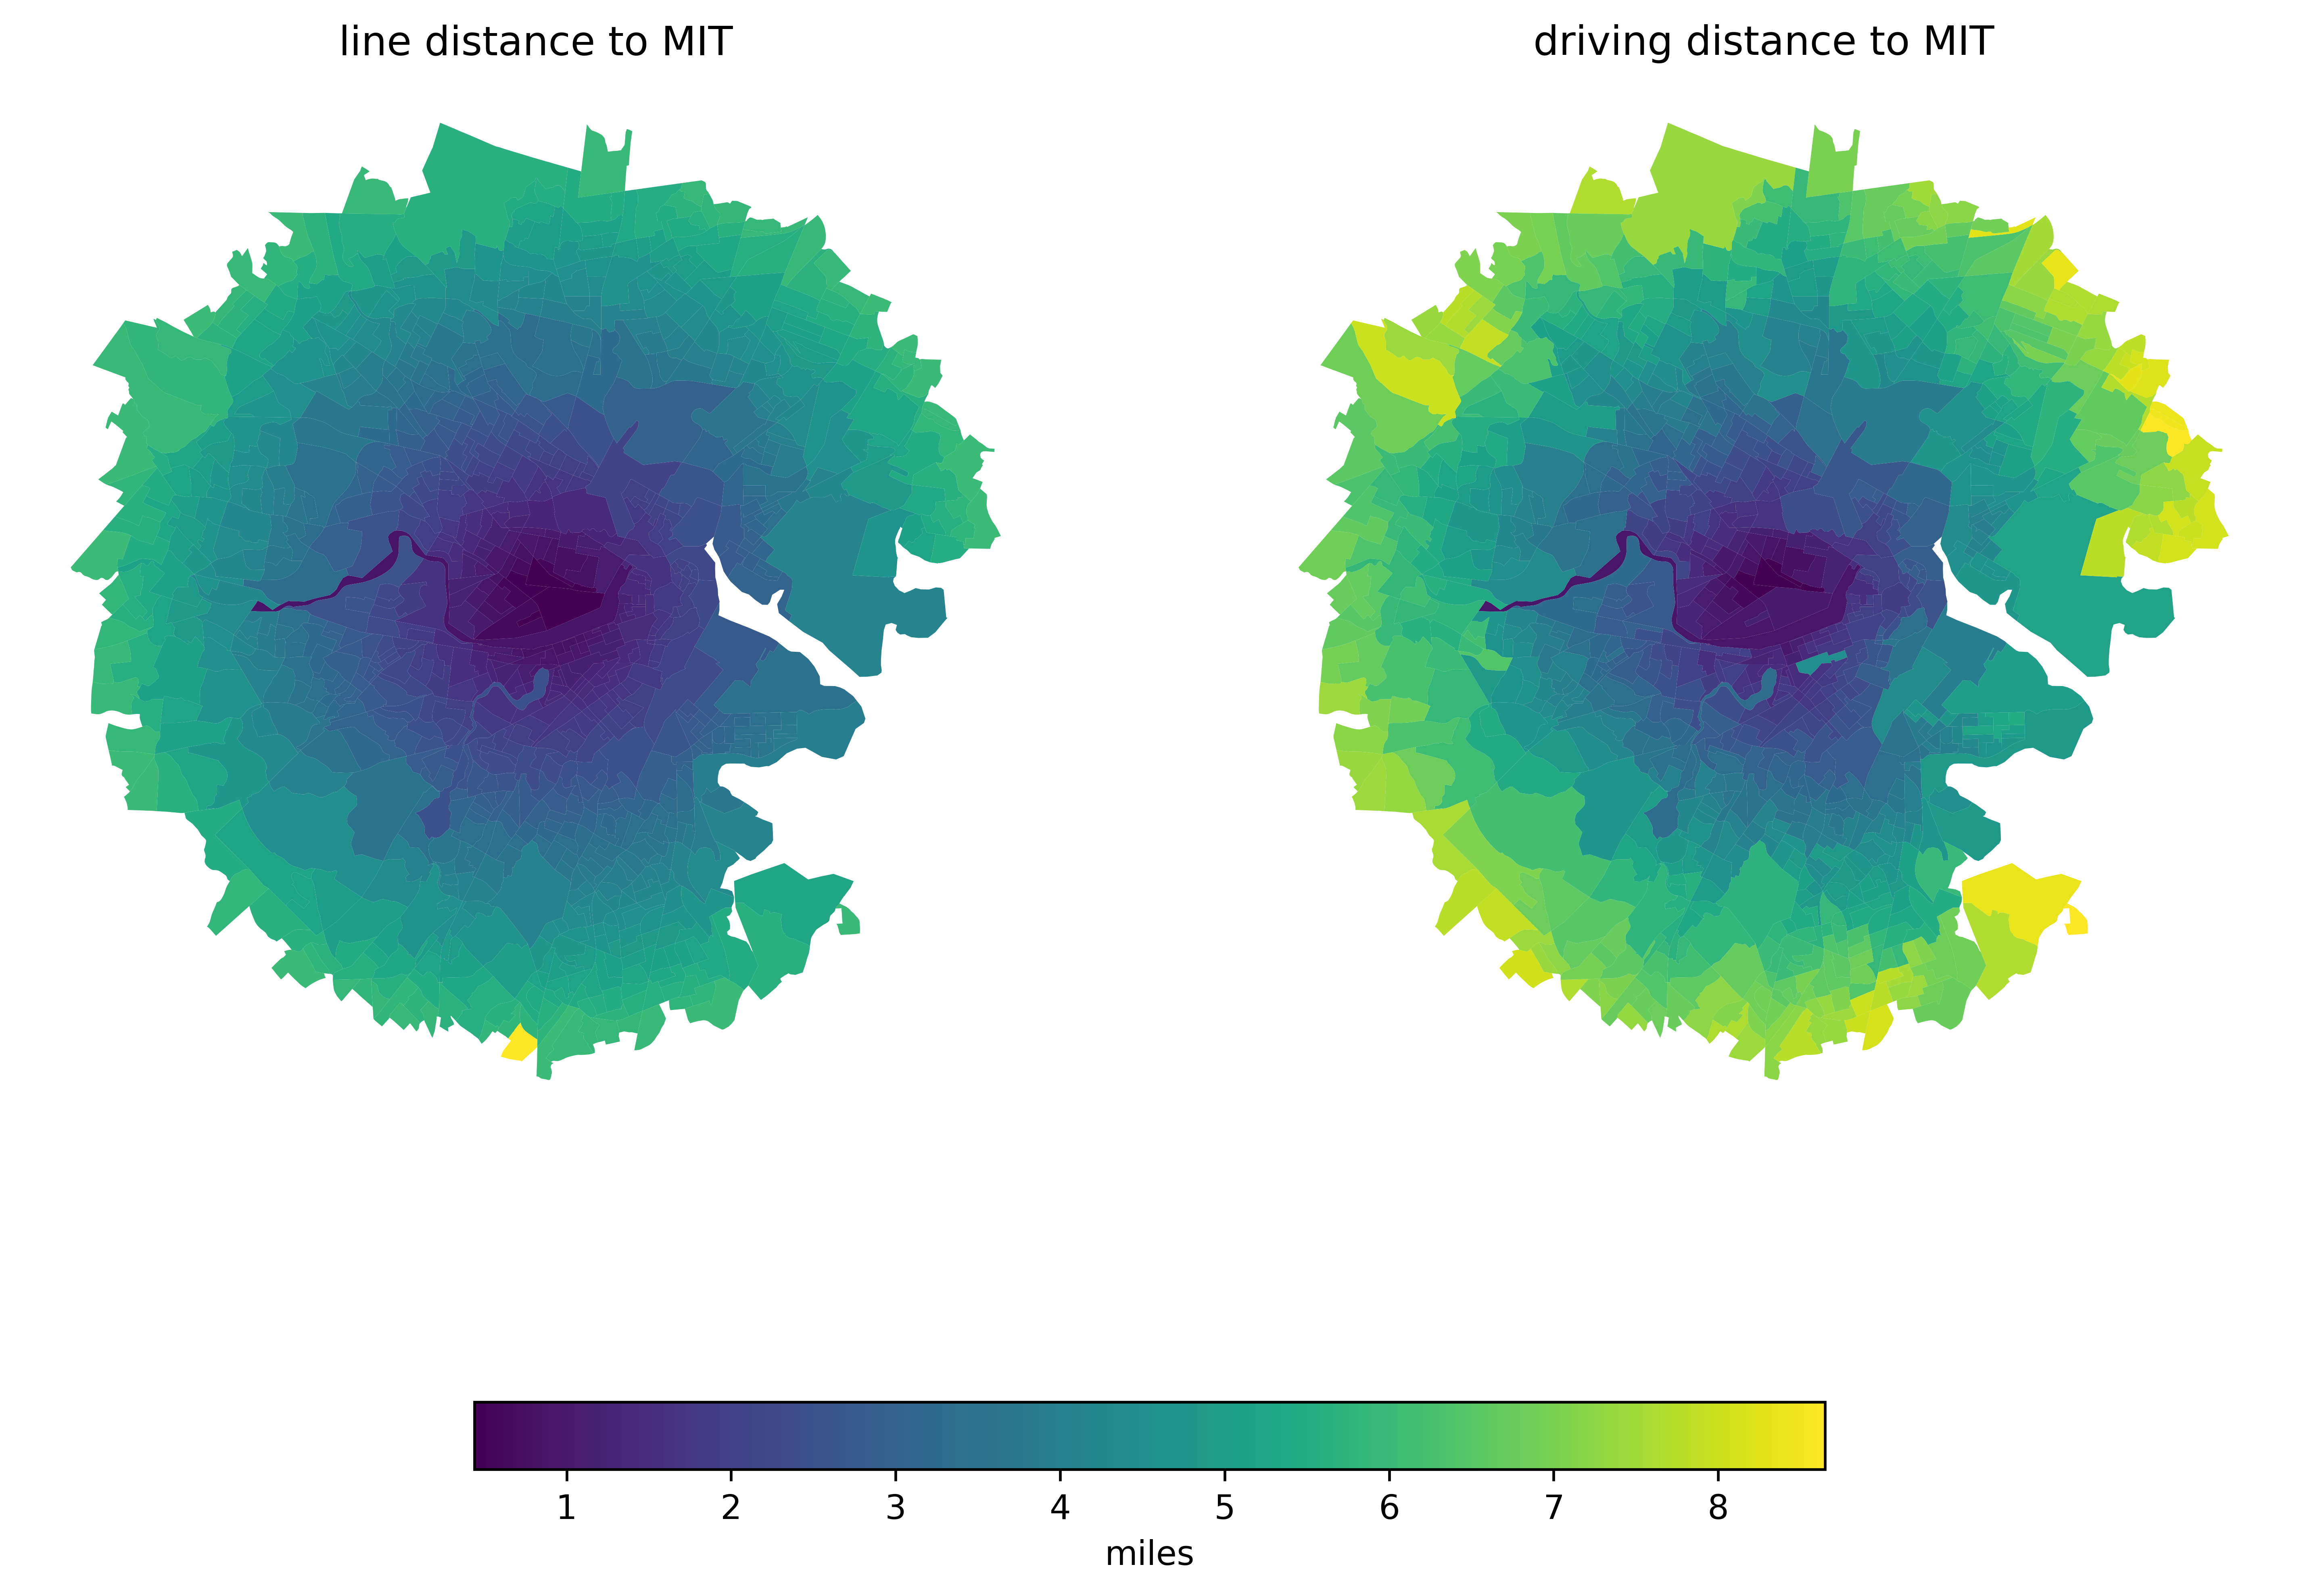

In [65]:
fig, ax = plt.subplots(1,2, dpi=300, figsize=(12,10), sharex=True, sharey=True)

#  mess  with  the plots so that they're colored with the same scale
bg_dist_plt = bg[bg['distance to MIT (miles)']<=6].copy()
line_max = bg_dist_plt['distance to MIT (miles)'].max()
drive_max = bg_dist_plt['driving distance to MIT (miles)'].max()
print('line max: ', line_max)
print('drive max: ', drive_max)
bg_dist_plt.loc['250251010016','distance to MIT (miles)'] = drive_max

bg_dist_plt.plot(
    column='distance to MIT (miles)',
    ax=ax[0],
)
bg_dist_plt.plot(
    column='driving distance to MIT (miles)',
    ax=ax[1],
)

cb = fig.colorbar(ax[1].collections[0],
                  ax=ax, 
                  shrink=0.6,
                  location='bottom',
                  label='miles'
)
ax[0].set_title('line distance to MIT')
ax[1].set_title('driving distance to MIT')
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.show()

In [66]:
# merge the survey data with  the shapefile
survey18_df = survey18_df.merge(bg, on=GEOID)

## Distance buckets

Individuals are bucketed by their distance to MIT.

Create the buckets and assign survey respondents to their buckets

```
< 1 mile
1 - 2 miles
2 - 3 miles
....
24 - 25 miles
> 25 miles

```


In [67]:
distance_buckets = list(range(1,26))


def get_distance_bucket_labels(distance_buckets):
    labels = []
    prev_val = 0
    for i, val in enumerate(distance_buckets):
        if i == 0:
            labels += ['< %s mile%s' % (val, '' if val == 1  else 's')]
        else:
            labels += ['%s - %s miles' % (prev_val, val)]
        prev_val = val
    labels += ['> %s miles' % val]
    return labels
            

def get_distance_bucket(distance):
    d = int(distance)
    if d < distance_buckets[0]:
        return 0
    for i in range(1, len(distance_buckets)):
        lower = distance_buckets[i-1]
        upper = distance_buckets[i]
        if (d >= lower and d < upper):
            return i
    if d >= distance_buckets[-1]:
        return len(distance_buckets)
    

assert(get_distance_bucket(0.2) == 0)
assert(get_distance_bucket(1.2) == 1)
assert(get_distance_bucket(1.9) == 1)
assert(get_distance_bucket(5.9) == 5)
assert(get_distance_bucket(26) == 25)

distance_bucket_labels = get_distance_bucket_labels(distance_buckets)
print(len(distance_buckets), 'distance buckets', distance_buckets)
print(len(distance_bucket_labels), 'distance bucket labels', distance_bucket_labels)

25 distance buckets [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
26 distance bucket labels ['< 1 mile', '1 - 2 miles', '2 - 3 miles', '3 - 4 miles', '4 - 5 miles', '5 - 6 miles', '6 - 7 miles', '7 - 8 miles', '8 - 9 miles', '9 - 10 miles', '10 - 11 miles', '11 - 12 miles', '12 - 13 miles', '13 - 14 miles', '14 - 15 miles', '15 - 16 miles', '16 - 17 miles', '17 - 18 miles', '18 - 19 miles', '19 - 20 miles', '20 - 21 miles', '21 - 22 miles', '22 - 23 miles', '23 - 24 miles', '24 - 25 miles', '> 25 miles']


In [68]:
survey18_df['distance bucket int'] = survey18_df['distance to MIT (miles)'].apply(get_distance_bucket)
survey18_df['distance bucket label'] = survey18_df['distance bucket int'].apply(lambda i: distance_bucket_labels[int(i)])

## Survey completions data

How many respondents answered that they went to campus at least 3 out of the 5 week days?

Note many respondents didn't answer about weekdays.

In [69]:
week_day_qs = [
    'week_1',
    'week_2',
    'week_3',
    'week_4',
    'week_5'
]
week_day_responses = set()
for wd in week_day_qs:
    week_day_responses.update(survey18_df[wd].unique())
print('week day responses:')
for r in week_day_responses:
    print(r)

week day responses:
nan
Other
Walked, then took public transportation
Bicycled
Drove alone, then took public transportation
Walked
Rode in a private car with 1-4 commuters
Shared ride/dropped off, then took public transportation
Rode in a vanpool (5+ commuters) or private shuttle (e.g. TechShuttle, SafeRide)
Drove alone the entire way
Dropped off at work
Scheduled day off (e.g., weekend)
Out of office (e.g., sick, vacation, jury duty, business trip)
Worked at home or other remote location
Bicycled and took public transportation
Took a taxi or ride service (e.g., Uber, Lyft)


In [70]:
#  Responses with no commute
week_day_resp_no_commute = [
    'Out of office (e.g., sick, vacation, jury duty, business trip)',
    'Worked at home or other remote location',
    'Scheduled day off (e.g., weekend)',
    np.nan,
]

def week_days_answered(row):
    """Returns the number of week day Q's the respondent answered."""
    return row[week_day_qs].notnull().sum()


def commute_days(row):
    """Returns the number of week days the person did commute."""
    assert(5 == len(week_day_qs))
    return 5 - row[week_day_qs].isin(week_day_resp_no_commute).sum()


survey18_df['week days answered'] = survey18_df.apply(week_days_answered, axis=1)
survey18_df['commute days'] = survey18_df.apply(commute_days,  axis=1)

In [71]:
print('How many respondents answered about at least 3 weekdays?')
a3 = len(survey18_df[survey18_df['week days answered'] >= 3])
print('%s / %s' % (a3, len(survey18_df)))
print('How many respondents answered about at least 5 weekdays?')
a5 = len(survey18_df[survey18_df['week days answered'] >= 5])
print('%s / %s' % (a5, len(survey18_df)))

How many respondents answered about at least 3 weekdays?
9426 / 20077
How many respondents answered about at least 5 weekdays?
9329 / 20077


How many respondents answered they commute at least 3 weekdays?

In [72]:
print('%s / %s' % (len(survey18_df[survey18_df['commute days']  >= 3]), len(survey18_df)))

9050 / 20077


Restrict the  survey to adequate completions and create aggregate estimates from that data.

- Q61: In the last year, have you driven to campus for work or study?
    - Answering YES to this is required in order for people to be asked whether they use MIT parking facilities -- which is data we need for MITOS and methodology validation
- all of 'week_1', ...'week_5' in response to question "Please indicate how you commuted TO CAMPUS each day LAST WEEK."

In [73]:
completions_df = survey18_df.loc[survey18_df[
    survey18_df['Q61'].notnull() & \
    survey18_df[week_day_qs].notnull().all(axis=1)
].index]
completions_n = len(completions_df)
print('%s / %s completion criteria met'%(completions_n, len(survey18_df)))
print('response rate = %.02f'%((completions_n/len(survey18_df))))

9173 / 20077 completion criteria met
response rate = 0.46


### Data representativeness

How well does this sample set represent the population?

Response rate by GEOID

Pearson correlation p = 0.992 


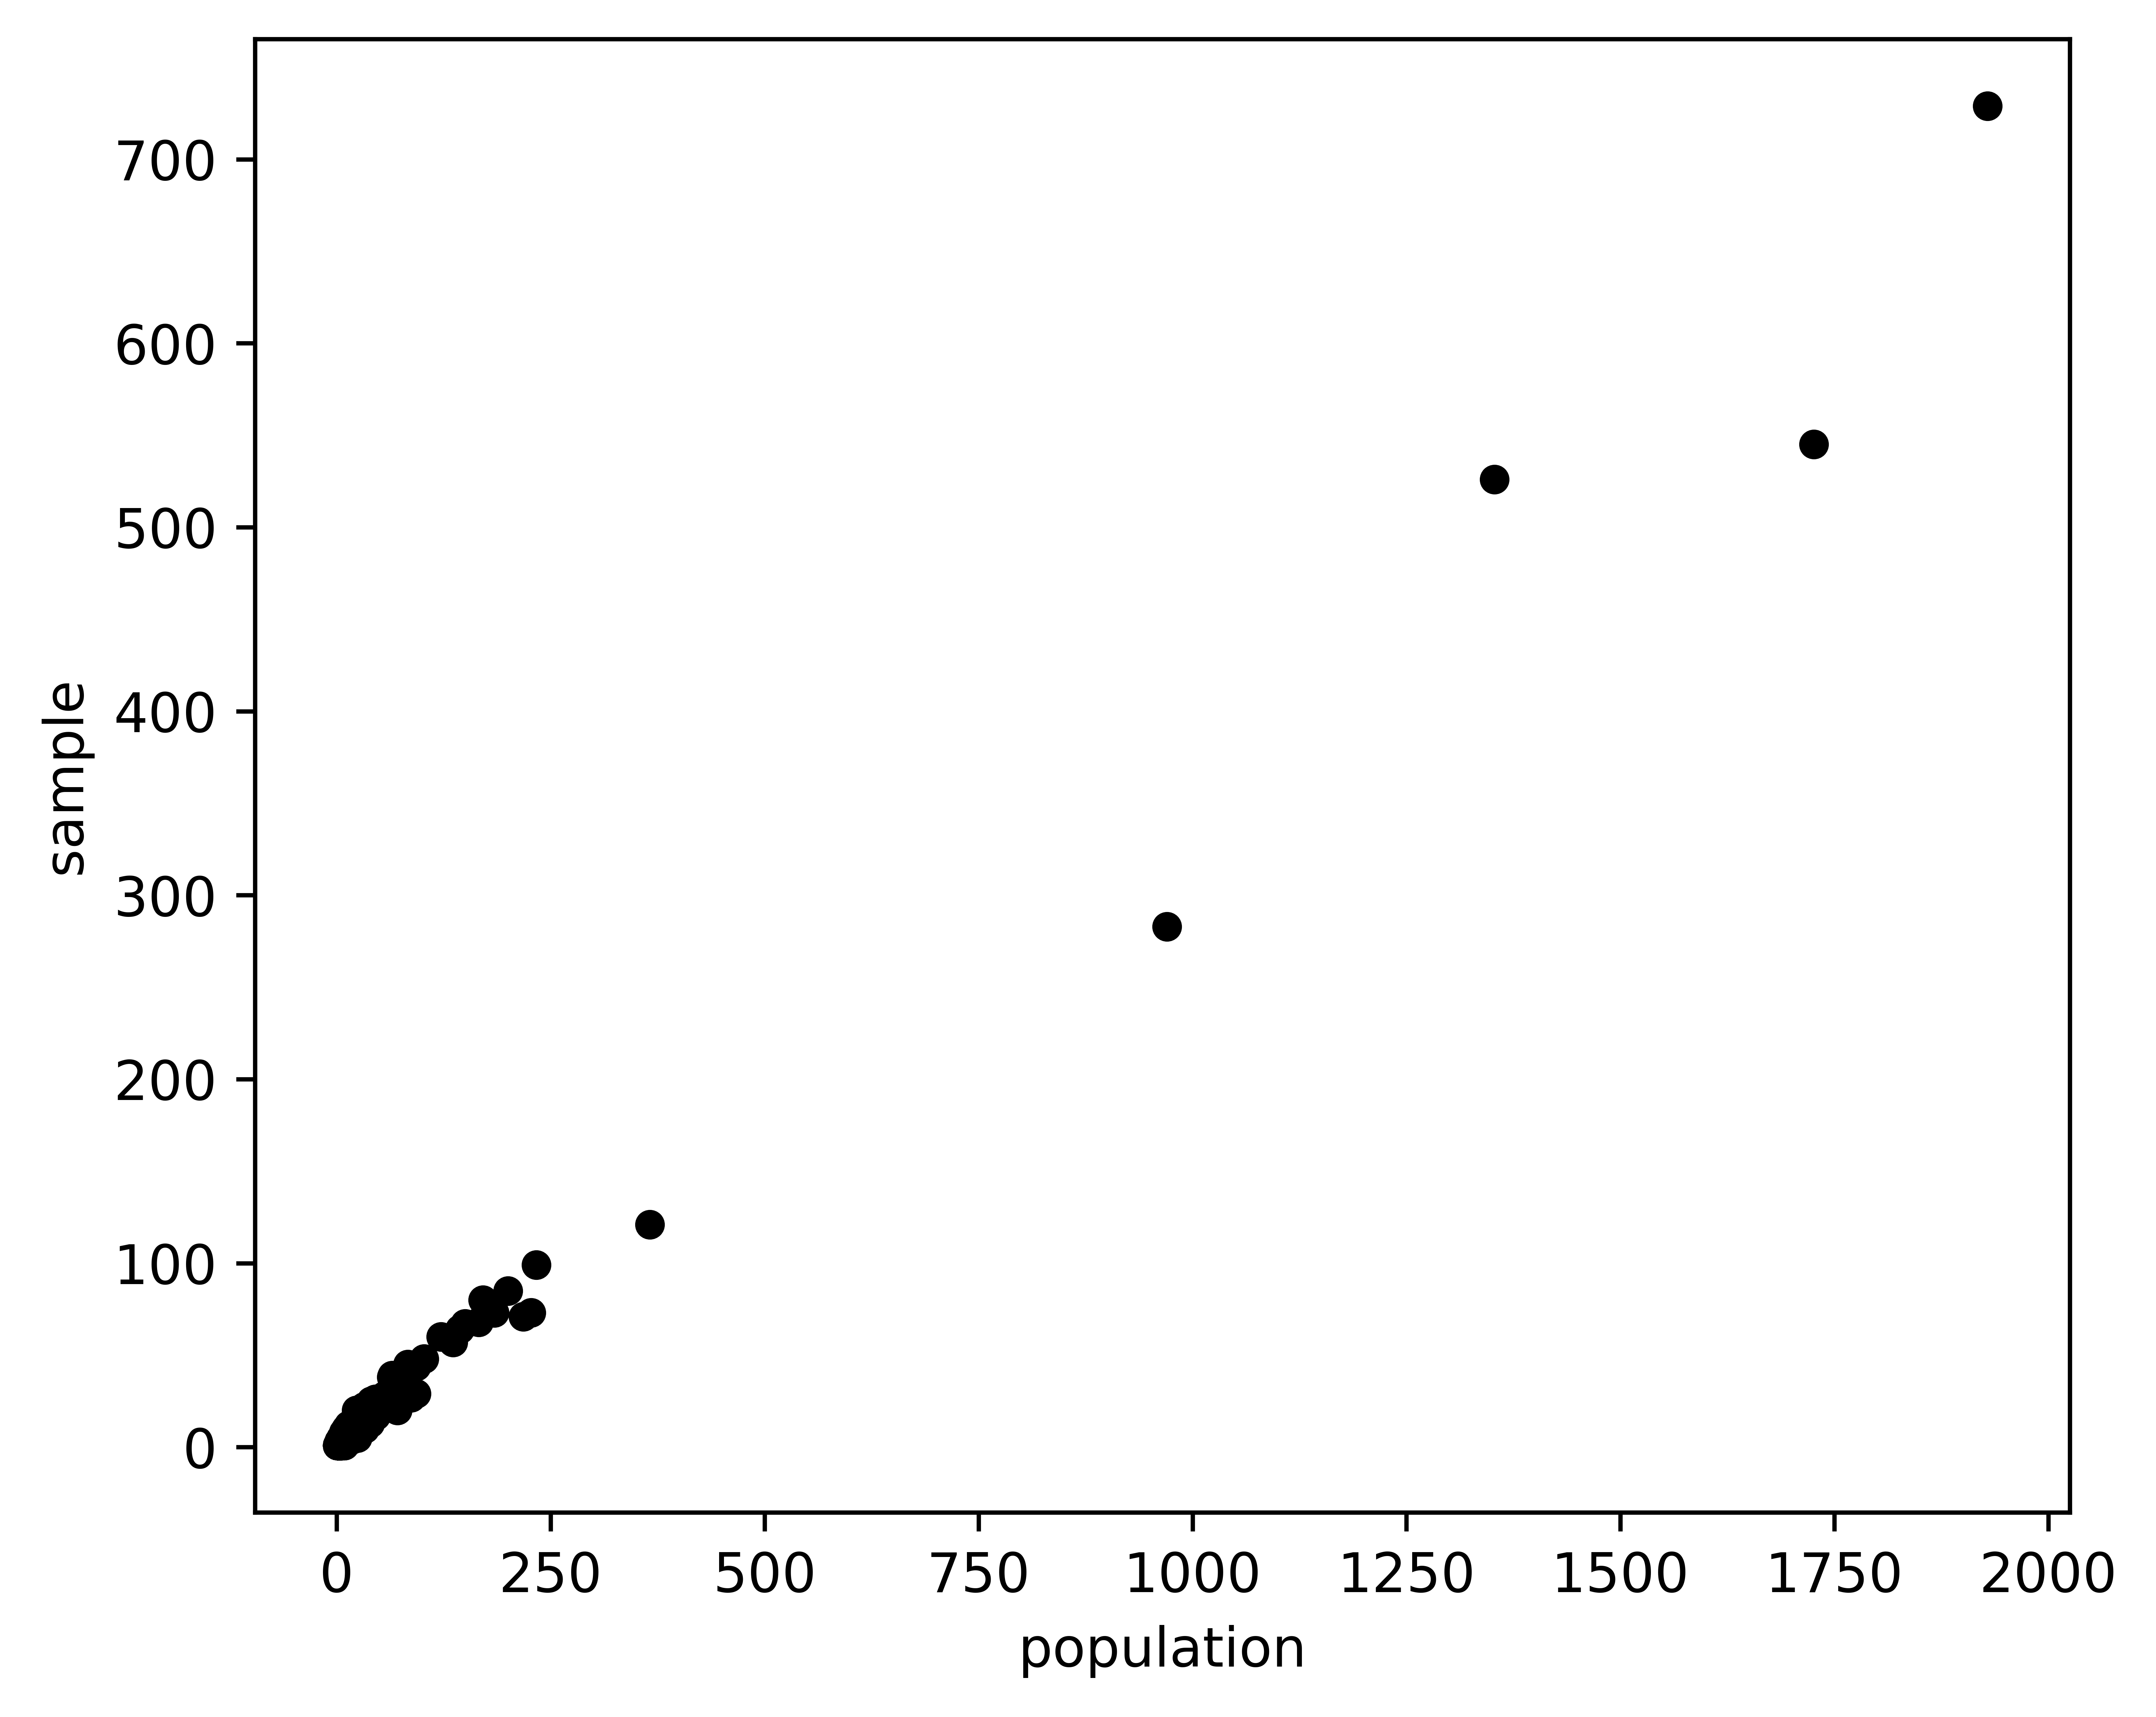

In [77]:
sample_geoids = completions_df[GEOID].value_counts()
population_geoids = survey18_df[GEOID].value_counts()
print('Pearson correlation p = %s ' %population_geoids.corr(sample_geoids).round(3))
geoids = pd.DataFrame({'sample': sample_geoids})
geoids['population'] = population_geoids
fig, ax = plt.subplots(1, 1, figsize=(6,5), dpi=600)
_ = geoids.plot.scatter('population', 'sample', ax=ax, color='black')
# _ = plt.title('population vs sample: residents in each census block group')

Response rate by academic group

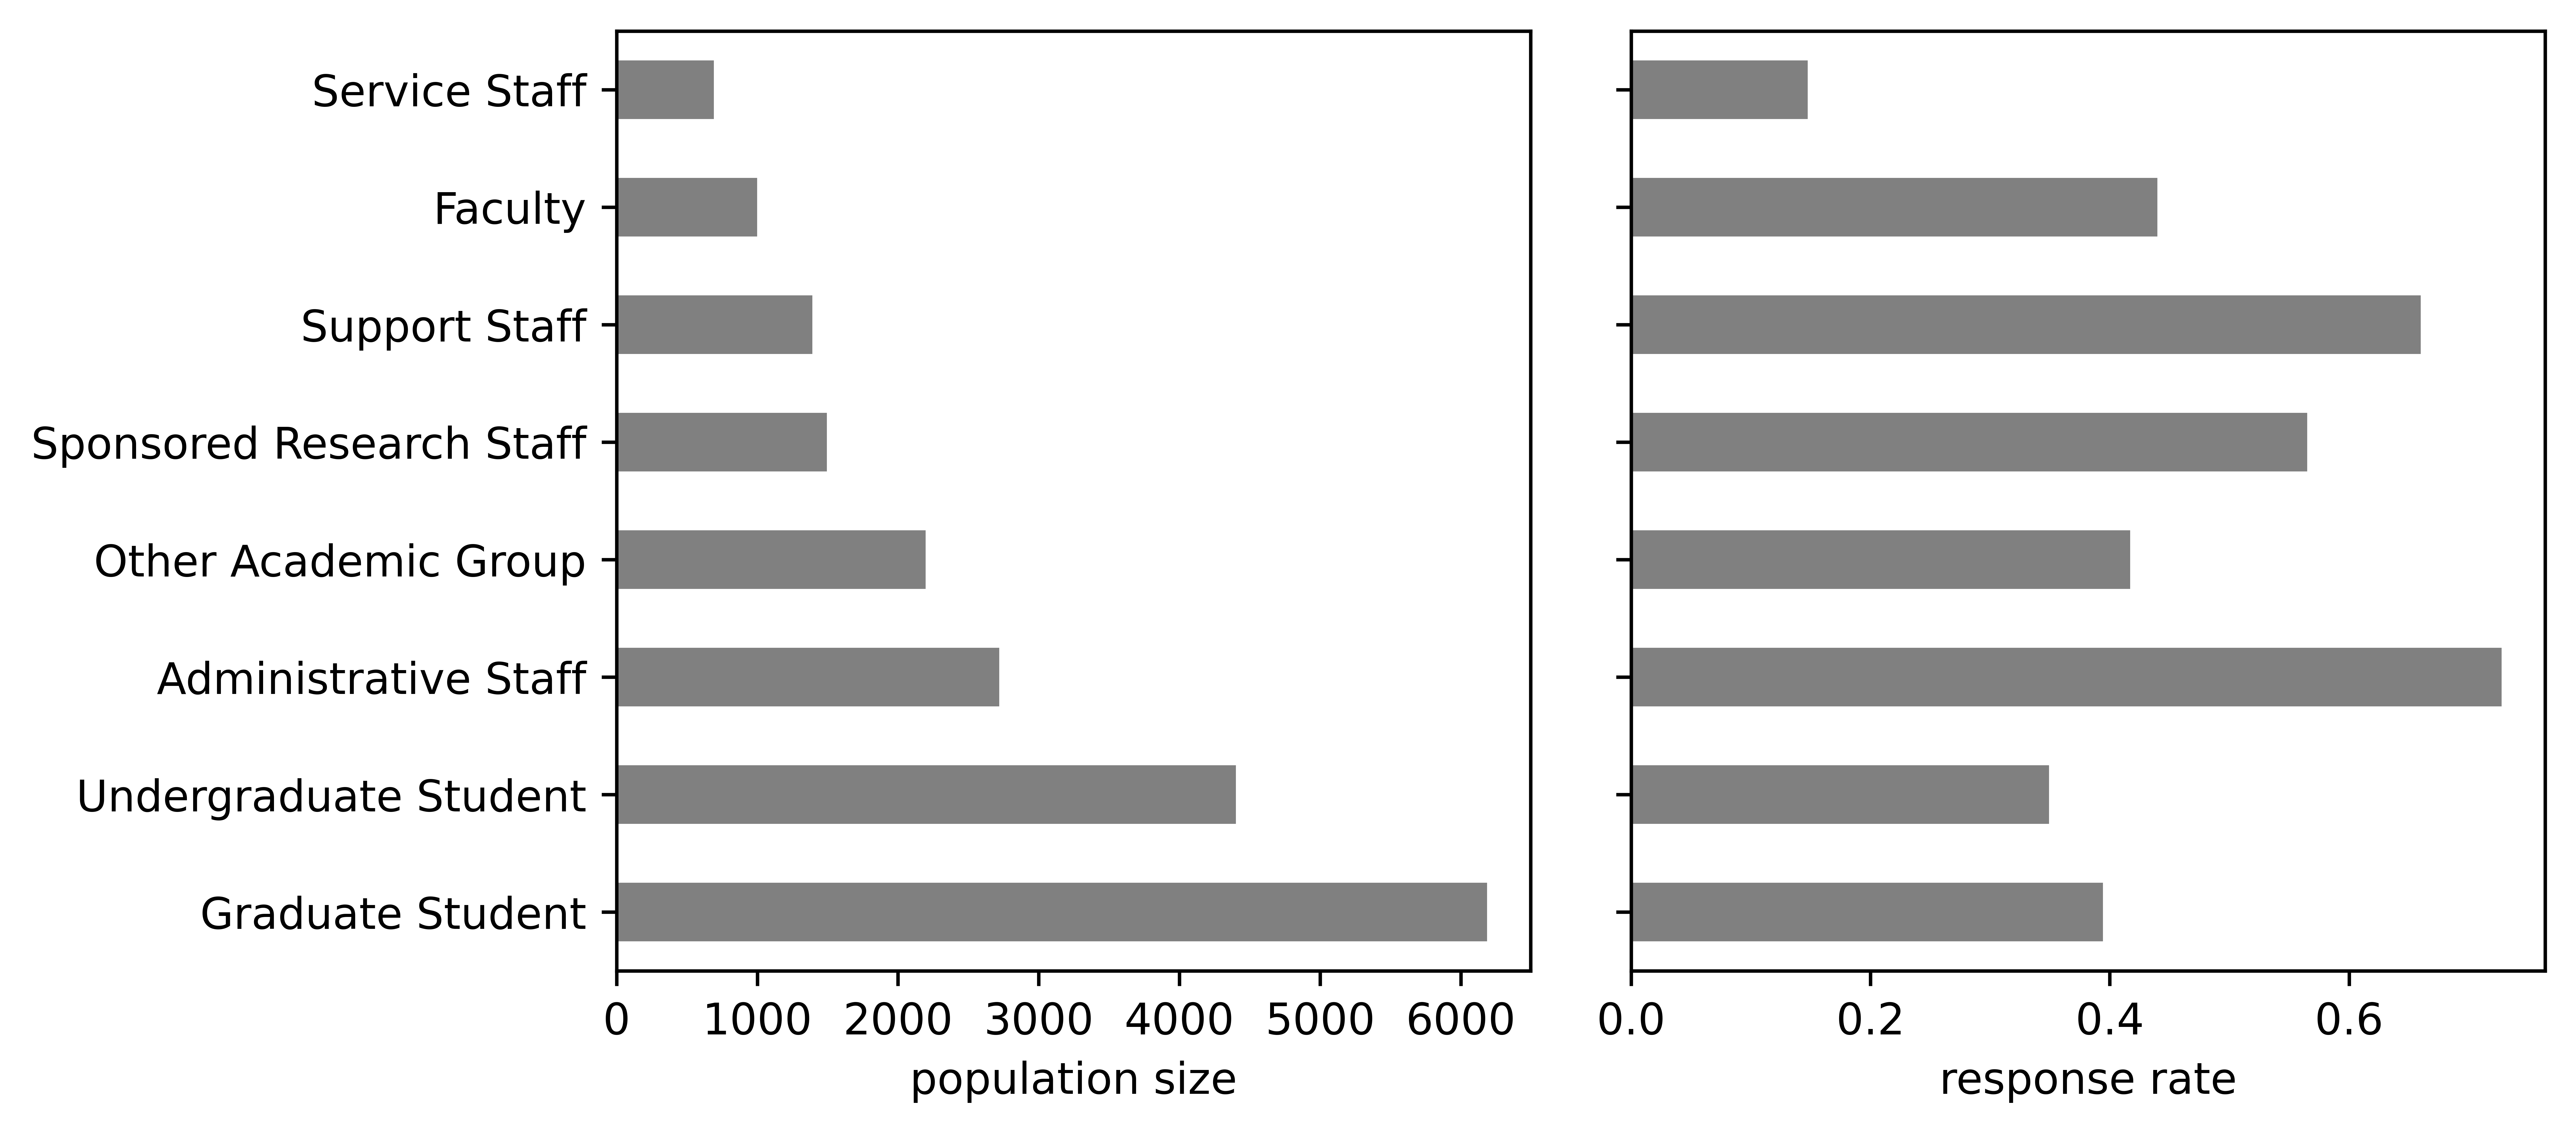

all  completions  response rate
Graduate Student          6187         2439       0.394214
Undergraduate Student     4401         1537       0.349239
Administrative Staff      2719         1978       0.727473
Other Academic Group      2196          916       0.417122
Sponsored Research Staff  1494          844       0.564926
Support Staff             1391          918       0.659957
Faculty                    998          439       0.439880
Service Staff              691          102       0.147612

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(8,4), dpi=600, sharey=True)
plt.subplots_adjust(wspace=0.11)
# fig.suptitle('MIT community size and response rate')
survey18_df['TYPE_NUM'].value_counts().plot.barh(ax=ax[0], color='gray')
ax[0].set_xlabel('population size')
types_df = survey18_df['TYPE_NUM'].value_counts().to_frame().rename(columns={'TYPE_NUM':'all'})
types_df['completions'] = types_df.index.map(completions_df['TYPE_NUM'].value_counts())
types_df['response rate'] = types_df['completions']/types_df['all']
types_df['response rate'].plot.barh(ax=ax[1], color='gray')
ax[1].set_xlabel('response rate')
plt.show()
types_df

In [ ]:
pp = pd.DataFrame({
    'N':types_df['all'],
    'completions':types_df['completions'],
    'response rate':types_df['response rate'].apply(lambda s: '%0.2f%%'%(100*s)),
})
print(tabulate(pp,headers='keys',tablefmt='latex'))
pp

### Set a flag for  MIT parking facility users

Used to estimate daily MIT parking facility users.

In [80]:
completions_df['PARKED'].value_counts()

MIT Parking Facility                       2032
On-street parking (meter, unrestricted)     570
Other paid parking lot or garage            326
On-street resident permit parking           249
Other (please specify)                      195
Name: PARKED, dtype: int64

In [81]:
USE_MIT_PARKING = 'use MIT parking'
completions_df[USE_MIT_PARKING] = completions_df['PARKED'].apply(lambda x: x=='MIT Parking Facility')

### Weight by driving days

Each person in the survey respondent sample is assigned a “car commuter” weight corresponding to how often they commuted to campus by driving alone. It is computed as  the fraction of weekdays (Monday  through Friday) they said they commuted by driving alone. 


They are also assigned a parking weight, equal to their car commuter weight, if they answered that they do use MIT parking  facilities.

These weights are used to estimate total daily car commuters, parking facility users, and distacne driven by car commuters.

Question:
-  By weekday: "Please indicate how you commuted TO CAMPUS each day LAST WEEK."
-  Q95_16: "What are your CURRENT commuting method(s) to MIT? (primary)"

Effectively only using answers by weekday with the sample restricted to those who completed those questions.

In [82]:
CAR_COMMUTER = 'car commuter' # weighted by days
CAR_COMMUTER_PARKING = 'car commuter parking' # weighted by days

def get_MIT_car_commuter_weight(row):
    if row[week_day_qs].notnull().all():
        return sum((row[d] == 'Drove alone the entire way') for d in week_day_qs)/len(week_day_qs)
    return 1 if row['Q95_16']=='Drive alone the entire way' else 0

def get_MIT_car_commuter_parking_weight(row):
    if not row[USE_MIT_PARKING]:
        return 0
    return get_MIT_car_commuter_weight(row)

completions_df[CAR_COMMUTER] = completions_df.apply(get_MIT_car_commuter_weight, axis=1)
completions_df[CAR_COMMUTER_PARKING] = completions_df.apply(get_MIT_car_commuter_parking_weight, axis=1)

In [83]:
completions_df[['TYPE_NUM', 'PARKED', 'Q95_16']+week_day_qs+[CAR_COMMUTER, CAR_COMMUTER_PARKING]].head()

TYPE_NUM                            PARKED  \
1      Administrative Staff              MIT Parking Facility   
3  Sponsored Research Staff                               NaN   
5      Administrative Staff  Other paid parking lot or garage   
7      Administrative Staff  Other paid parking lot or garage   
8             Support Staff              MIT Parking Facility   

                                     Q95_16  \
1     Walk, then take public transportation   
3     Walk, then take public transportation   
5                Drive alone the entire way   
7                Drive alone the entire way   
8  Ride in a private car with 1-4 commuters   

                                     week_1  \
1   Worked at home or other remote location   
3   Worked at home or other remote location   
5                Drove alone the entire way   
7                Drove alone the entire way   
8  Rode in a private car with 1-4 commuters   

                                     week_2  \
1   Walked, then took public transportation   
3   Walked, then took public transportation   
5                Drove alone the entire way   
7                Drove alone the entire way   
8  Rode in a private car with 1-4 commuters   

                                     week_3  \
1   Walked, then took public transportation   
3   Walked, then took public transportation   
5                Drove alone the entire way   
7                Drove alone the entire way   
8  Rode in a private car with 1-4 commuters   

                                     week_4  \
1   Worked at home or other remote location   
3   Walked, then took public transportation   
5                Drove alone the entire way   
7                Drove alone the entire way   
8  Rode in a private car with 1-4 commuters   

                                     week_5  car commuter  \
1   Worked at home or other remote location           0.0   
3   Walked, then took public transportation           0.0   
5                Drove alone the entire way           1.0   
7   Worked at home or other remote location           0.8   
8  Rode in a private car with 1-4 commuters           0.0   

   car commuter parking  
1                   0.0  
3                   0.0  
5                   0.0  
7                   0.0  
8                   0.0

In [84]:
car_commuter_dist = completions_df[CAR_COMMUTER].value_counts().rename('N').to_frame()
car_commuter_dist = car_commuter_dist.reset_index().sort_values('index').rename(
    columns={'index':'car commuter weight'}
)
car_commuter_dist

car commuter weight     N
0                  0.0  7524
3                  0.2   285
4                  0.4   196
5                  0.6   190
2                  0.8   310
1                  1.0   668

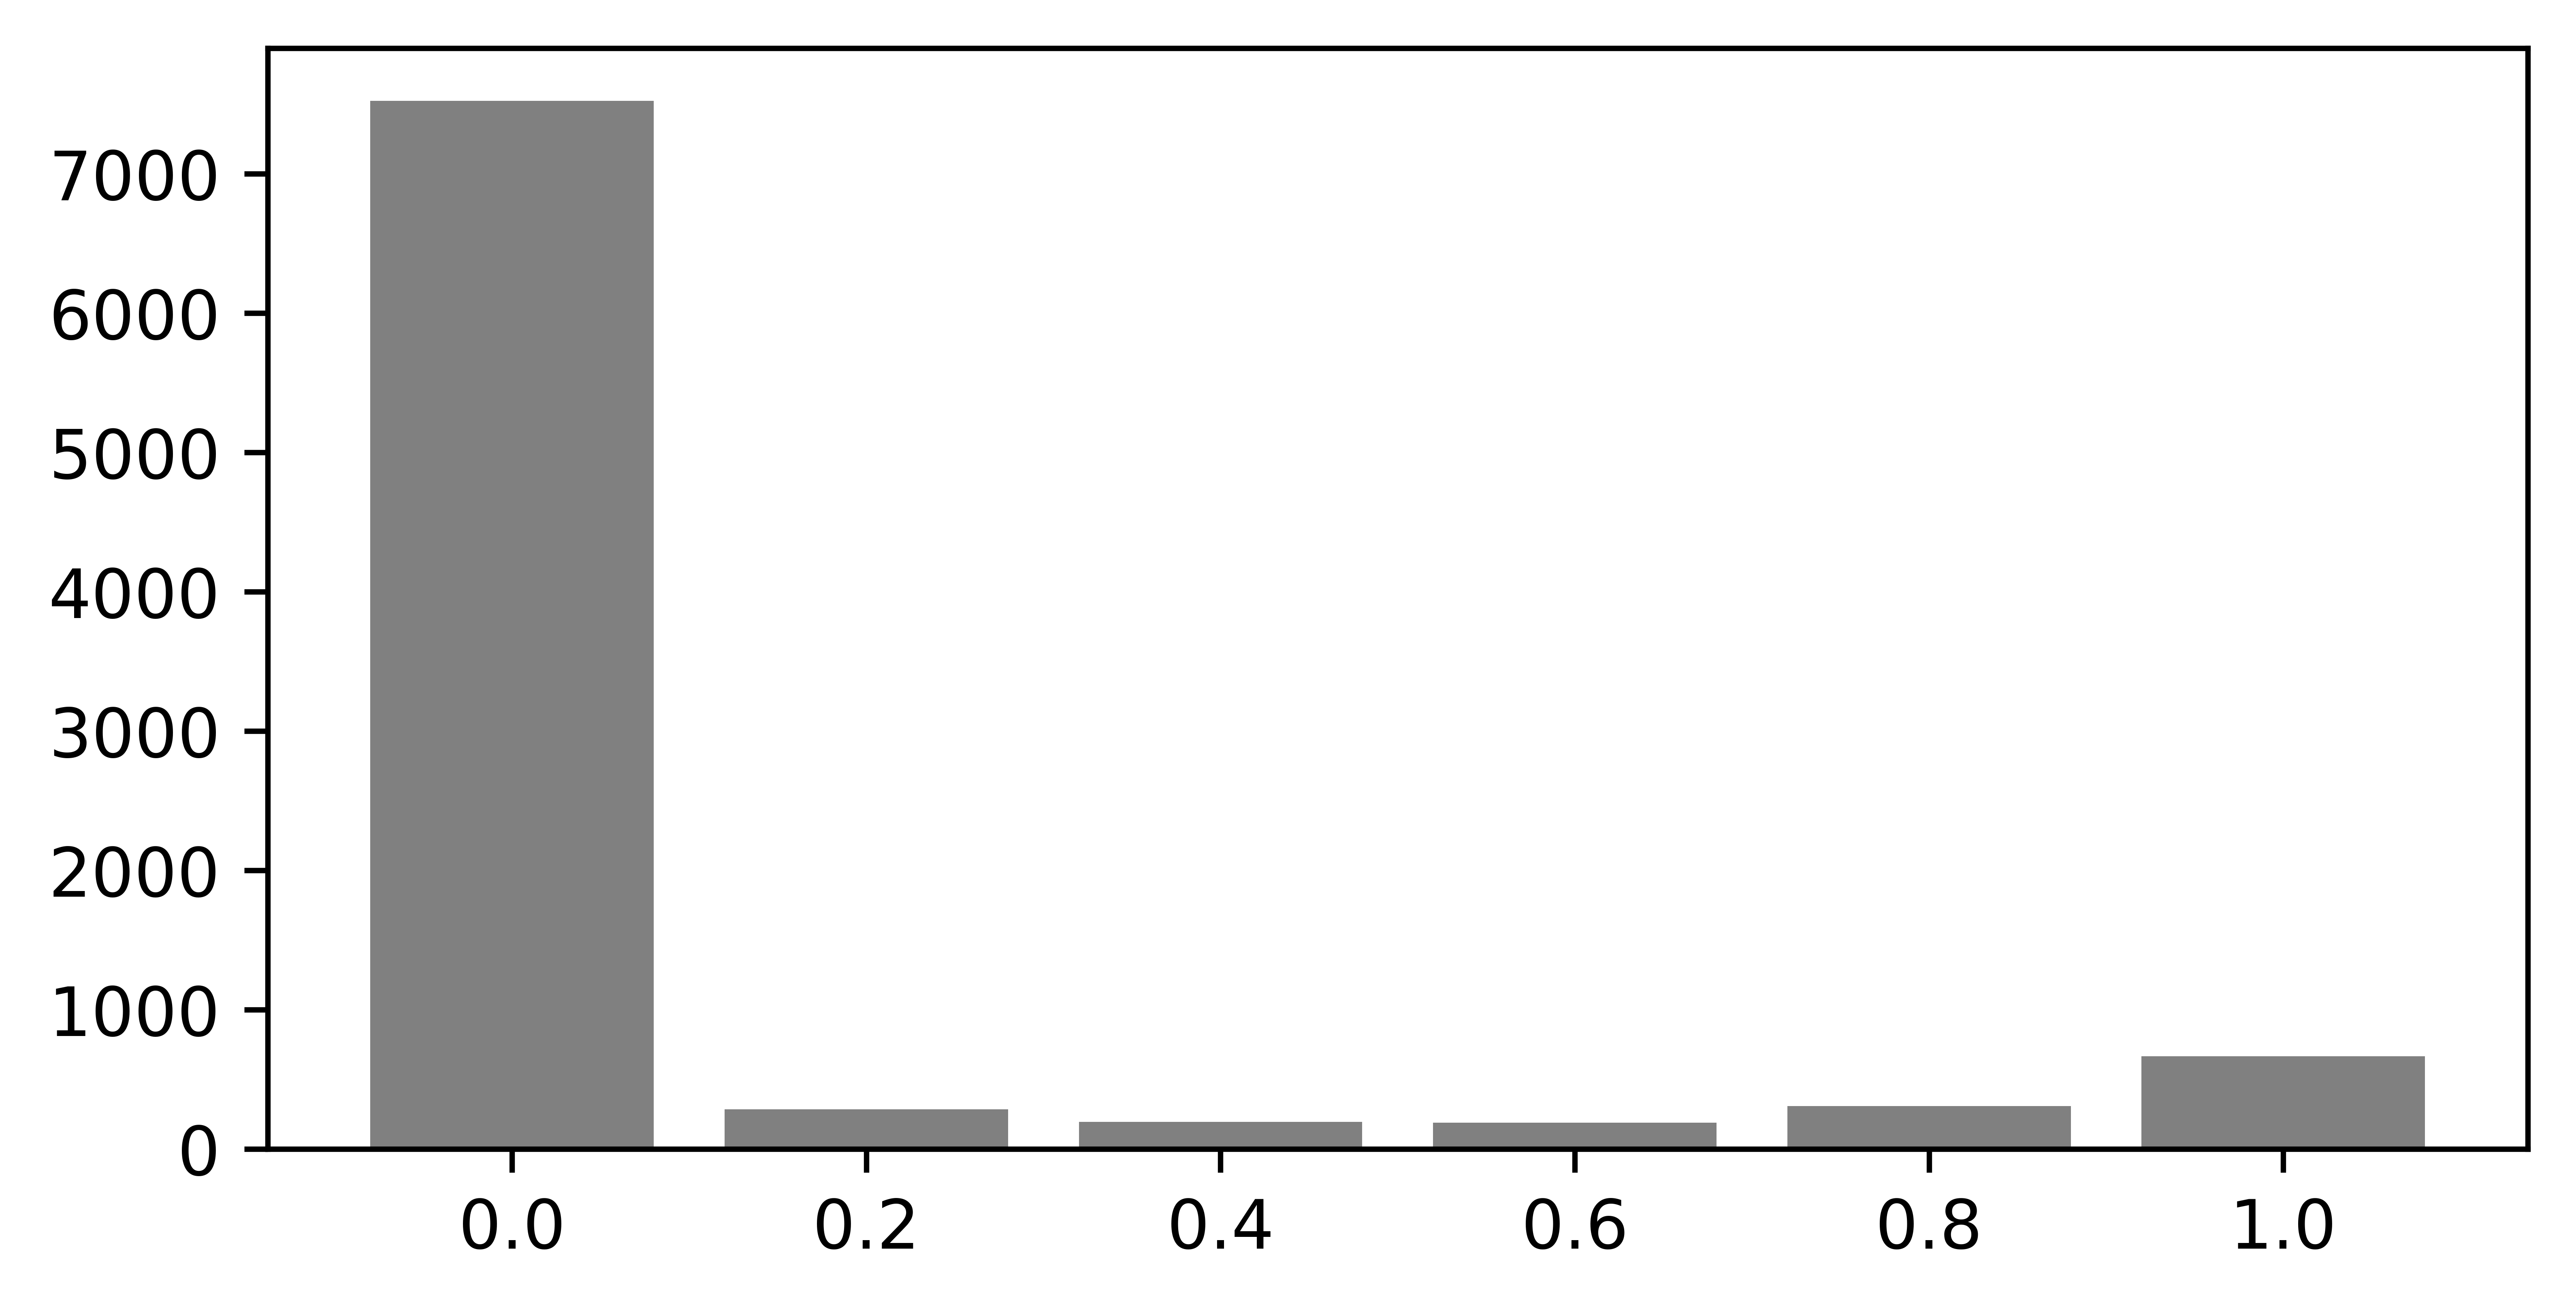

In [85]:
fig, ax = plt.subplots(1,1, figsize=(6,3),dpi=600)
_ = ax.bar(
    car_commuter_dist['car commuter weight'].astype(str), 
    car_commuter_dist['N'],
    color='gray',
)
# _ = plt.title('Distribution of car commuter weights for survey respondents')

In [86]:
n = len(completions_df)
print('total completions:', n)
print('%s: %s / %s' % (USE_MIT_PARKING, completions_df[USE_MIT_PARKING].sum(), n))
print('car commuters (weighted by day): %s / %s'%(round(completions_df[CAR_COMMUTER].sum()), n))

total completions: 9173
use MIT parking: 2032 / 9173
car commuters (weighted by day): 1165 / 9173


### Driving distance weights

Each respondent is assigned a driving distance weight computed as 2 x their driving distance multiplied by their car commuter weight. This represents their average daily miles driving alone to MIT.

In [87]:
DRIVING_DISTANCE_WEIGHT = 'driving distance weight'
completions_df[DRIVING_DISTANCE_WEIGHT] = 2 * completions_df[CAR_COMMUTER] * completions_df['driving distance to MIT (miles)']

### Analysis by group

Partition individuals by  academic group x distance bucket

Compute weights for each partition.

Let 
- $ N_j$ = partition j population  size
- $n_j$ = partition j sample size    

$ \frac{N_j}{n_j} =$ partition j weight


In [88]:
# N = population count
partitions =  survey18_df.groupby(
    ['TYPE_NUM', 'distance bucket int']
).count()['PID'].rename('N').to_frame()
partitions['distance bucket label'] = partitions.index.map(lambda x: distance_bucket_labels[x[1]])
partitions = partitions[['distance bucket label', 'N']] # sort columns
# n = sample count (survey completions)
partitions['n'] = completions_df.groupby(
    ['TYPE_NUM', 'distance bucket int']
).count()['PID']
partitions['weight'] = partitions['N']/partitions['n']

partitions.head()

distance bucket label    N      n  \
TYPE_NUM             distance bucket int                                     
Administrative Staff 0                                < 1 mile  156  115.0   
                     1                             1 - 2 miles  274  191.0   
                     2                             2 - 3 miles  283  217.0   
                     3                             3 - 4 miles  249  193.0   
                     4                             4 - 5 miles  196  144.0   

                                            weight  
TYPE_NUM             distance bucket int            
Administrative Staff 0                    1.356522  
                     1                    1.434555  
                     2                    1.304147  
                     3                    1.290155  
                     4                    1.361111

### Sample values by group

In [89]:
sample = completions_df.copy()

### Bootstrap sampling  to create distribution and confidence intervals for baseline estimates

Use bootstrap to resample and compute the sample estimates for daily car commuters, car commuters parking and total driving distance by car commuters.

In [90]:
from sklearn.utils import resample

bs_iter = 10000


# Create sample frames from bootstrapping the sample

car_commuters_samples = None
car_commuters_parking_samples = None
car_commuters_driving_dist_samples = None


for i in range(bs_iter):
    s = resample(sample).groupby(
        ['TYPE_NUM', 'distance bucket int']
    ).sum()
    
    if i == 0:
        # initialize the samples frames
        car_commuters_samples = s['car commuter'].to_frame().rename(columns={'car commuter': 0})
        car_commuters_parking_samples = s['car commuter parking'].to_frame().rename(columns={'car commuter parking': 0})
        car_commuters_driving_dist_samples = s[DRIVING_DISTANCE_WEIGHT].to_frame().rename(columns={DRIVING_DISTANCE_WEIGHT: 0})
    else:
        car_commuters_samples[i] = s['car commuter']
        car_commuters_parking_samples[i] = s['car commuter parking']
        car_commuters_driving_dist_samples[i] = s[DRIVING_DISTANCE_WEIGHT]

# car_commuters_driving_dist_samples

### Baseline estimates

### Baseline estimates for the totals

mean = 2146.09
95% CI [2144.74, 2147.45]


0          1          2     \
TYPE_NUM              distance bucket int                                    
Administrative Staff  0                    12.208696  12.480000   7.053913   
                      1                    32.420942  29.264921  30.412565   
                      2                    32.342857  31.560369  35.472811   
                      3                    45.671503  47.477720  45.413472   
                      4                    52.538889  66.422222  40.833333   
...                                              ...        ...        ...   
Undergraduate Student 5                          NaN        NaN        NaN   
                      8                          NaN        NaN        NaN   
                      22                    1.000000        NaN   1.000000   
                      23                         NaN        NaN        NaN   
                      25                    0.000000        NaN   0.000000   

                                                3          4          5     \
TYPE_NUM              distance bucket int                                    
Administrative Staff  0                     4.069565   7.596522  14.379130   
                      1                    41.602094  15.493194  24.674346   
                      2                    42.254378  39.385253  39.385253   
                      3                    27.867358  45.671503  39.736788   
                      4                    55.805556  40.833333  44.916667   
...                                              ...        ...        ...   
Undergraduate Student 5                          NaN        NaN        NaN   
                      8                          NaN        NaN        NaN   
                      22                    3.000000   1.000000   2.000000   
                      23                         NaN        NaN        NaN   
                      25                    0.000000   0.000000   0.000000   

                                                6          7          8     \
TYPE_NUM              distance bucket int                                    
Administrative Staff  0                    14.107826   5.968696  10.309565   
                      1                    37.872251  22.952880  28.691099   
                      2                    41.471889  46.427650  38.081106   
                      3                    31.221762  50.832124  45.413472   
                      4                    56.350000  51.450000  56.077778   
...                                              ...        ...        ...   
Undergraduate Student 5                          NaN        NaN        NaN   
                      8                          NaN        NaN        NaN   
                      22                    2.000000   2.000000   2.000000   
                      23                         NaN        NaN        NaN   
                      25                    0.000000        NaN   0.000000   

                                                9     ...       9990  \
TYPE_NUM              distance bucket int             ...              
Administrative Staff  0                    13.836522  ...  11.666087   
                      1                    29.264921  ...  26.108901   
                      2                    33.647005  ...  44.862673   
                      3                    49.541969  ...  45.929534   
                      4                    44.100000  ...  55.261111   
...                                              ...  ...        ...   
Undergraduate Student 5                          NaN  ...        NaN   
                      8                          NaN  ...        NaN   
                      22                    1.000000  ...   2.000000   
                      23                         NaN  ...        NaN   
                      25                    0.000000  ...   0.000000   

                                                9991       9992   

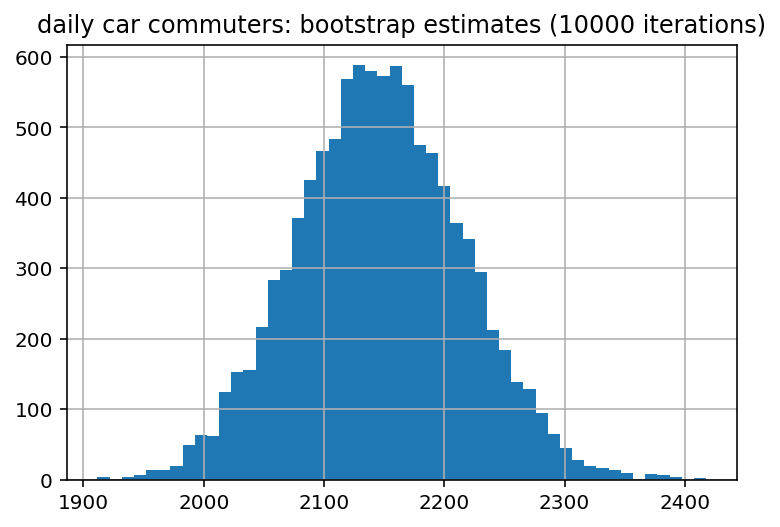

In [91]:
# multiply by the partition weights
baseline_car_commuters = car_commuters_samples.apply(lambda x: x.multiply(partitions['weight']))
baseline_car_commuters_totals = baseline_car_commuters.sum()
baseline_car_commuters_totals.hist(bins=50)
plt.title('daily car commuters: bootstrap estimates (%s iterations)' % bs_iter)
print('mean = %0.2f' % baseline_car_commuters_totals.mean())
# create 95% confidence interval for population
ci = stats.norm.interval(alpha=0.95,
                 loc=np.mean(baseline_car_commuters_totals), 
                 scale=stats.sem(baseline_car_commuters_totals))
print('95%% CI [%0.2f, %0.2f]' % ci)
baseline_car_commuters

In [92]:
# multiply by the partition weights
baseline_car_commuters_parking = car_commuters_parking_samples.apply(lambda x: x.multiply(partitions['weight']))
baseline_car_commuters_parking

0          1          2     \
TYPE_NUM              distance bucket int                                    
Administrative Staff  0                     6.240000   7.053913   5.426087   
                      1                    23.526702  15.493194  21.231414   
                      2                    28.691244  26.865438  28.952074   
                      3                    31.995855  35.092228  36.640415   
                      4                    43.827778  53.083333  35.933333   
...                                              ...        ...        ...   
Undergraduate Student 5                          NaN        NaN        NaN   
                      8                          NaN        NaN        NaN   
                      22                    0.000000        NaN   0.000000   
                      23                         NaN        NaN        NaN   
                      25                    0.000000        NaN   0.000000   

                                                3          4          5     \
TYPE_NUM              distance bucket int                                    
Administrative Staff  0                     2.170435   3.526957   6.240000   
                      1                    32.707853  10.041885  18.649215   
                      2                    31.038710  30.256221  35.472811   
                      3                    20.126425  28.641451  29.673575   
                      4                    53.083333  39.744444  39.744444   
...                                              ...        ...        ...   
Undergraduate Student 5                          NaN        NaN        NaN   
                      8                          NaN        NaN        NaN   
                      22                    0.000000   0.000000   0.000000   
                      23                         NaN        NaN        NaN   
                      25                    0.000000   0.000000   0.000000   

                                                6          7          8     \
TYPE_NUM              distance bucket int                                    
Administrative Staff  0                     5.426087   2.713043   2.170435   
                      1                    31.273298  17.788482  22.379058   
                      2                    34.168664  37.820276  26.604608   
                      3                    23.738860  38.446632  37.414508   
                      4                    52.266667  50.361111  50.905556   
...                                              ...        ...        ...   
Undergraduate Student 5                          NaN        NaN        NaN   
                      8                          NaN        NaN        NaN   
                      22                    0.000000   0.000000   0.000000   
                      23                         NaN        NaN        NaN   
                      25                    0.000000        NaN   0.000000   

                                                9     ...       9990  \
TYPE_NUM              distance bucket int             ...              
Administrative Staff  0                     5.968696  ...   5.426087   
                      1                    18.936126  ...  14.345550   
                      2                    30.256221  ...  34.951152   
                      3                    31.479793  ...  29.673575   
                      4                    40.288889  ...  45.733333   
...                                              ...  ...        ...   
Undergraduate Student 5                          NaN  ...        NaN   
                      8                          NaN  ...        NaN   
                      22                    0.000000  ...   0.000000   
                      23                         NaN  ...        NaN   
                      25                    0.000000  ...   0.000000   

                                                9991       9992   

mean = 1752.66
95% CI [1751.45, 1753.87]


(1751.4522399082832, 1753.87328775616)

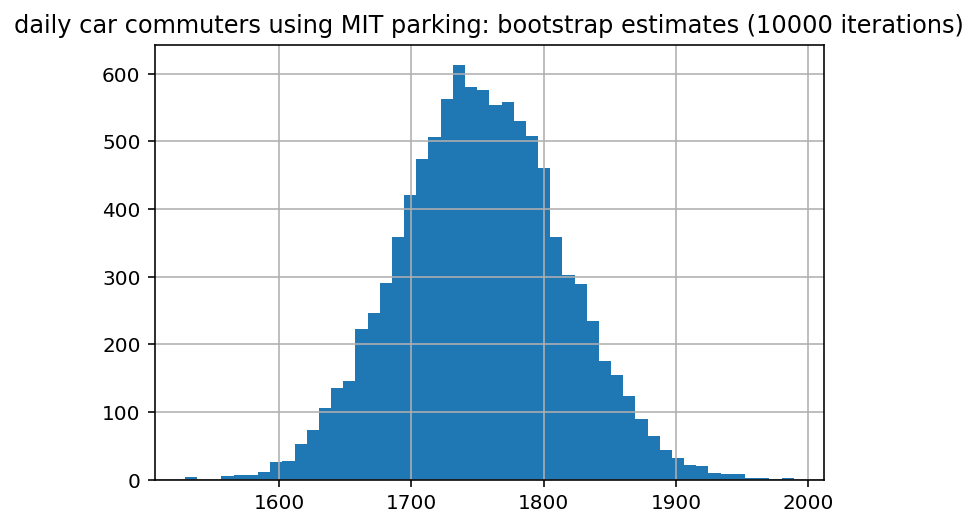

In [93]:
baseline_car_commuters_parking_totals = baseline_car_commuters_parking.sum()
baseline_car_commuters_parking_totals.hist(bins=50)
plt.title('daily car commuters using MIT parking: bootstrap estimates (%s iterations)' % bs_iter)
print('mean = %0.2f' % baseline_car_commuters_parking_totals.mean())
# create 95% confidence interval for population
ci = stats.norm.interval(alpha=0.95,
                 loc=np.mean(baseline_car_commuters_parking_totals), 
                 scale=stats.sem(baseline_car_commuters_parking_totals))
print('95%% CI [%0.2f, %0.2f]' % ci)
ci

In [94]:
# multiply by the partition weights
baseline_car_commuters_driving_dist = car_commuters_driving_dist_samples.apply(lambda x: x.multiply(partitions['weight']))
baseline_car_commuters_driving_dist

0           1           2     \
TYPE_NUM              distance bucket int                                       
Administrative Staff  0                     26.233072   28.032501   12.590480   
                      1                    145.790255  131.733128  128.229214   
                      2                    207.752880  206.067592  229.891575   
                      3                    402.190930  429.298179  409.225413   
                      4                    585.631122  743.865179  448.189275   
...                                               ...         ...         ...   
Undergraduate Student 5                           NaN         NaN         NaN   
                      8                           NaN         NaN         NaN   
                      22                    56.214937         NaN   56.214937   
                      23                          NaN         NaN         NaN   
                      25                     0.000000         NaN    0.000000   

                                                 3           4           5     \
TYPE_NUM              distance bucket int                                       
Administrative Staff  0                      8.822938   17.560372   31.759415   
                      1                    188.407724   68.178707  112.374936   
                      2                    274.541504  251.162700  253.970271   
                      3                    258.753629  411.751524  360.317873   
                      4                    616.629226  461.002564  507.843587   
...                                               ...         ...         ...   
Undergraduate Student 5                           NaN         NaN         NaN   
                      8                           NaN         NaN         NaN   
                      22                   168.644812   56.214937  112.429875   
                      23                          NaN         NaN         NaN   
                      25                     0.000000    0.000000    0.000000   

                                                 6           7           8     \
TYPE_NUM              distance bucket int                                       
Administrative Staff  0                     33.943614   14.620562   22.543077   
                      1                    172.107608  105.248694  134.341267   
                      2                    261.091580  300.401791  243.422211   
                      3                    277.274404  465.469440  424.297232   
                      4                    628.979887  579.022393  636.374695   
...                                               ...         ...         ...   
Undergraduate Student 5                           NaN         NaN         NaN   
                      8                           NaN         NaN         NaN   
                      22                   112.429875  112.429875  112.429875   
                      23                          NaN         NaN         NaN   
                      25                     0.000000         NaN    0.000000   

                                                 9     ...        9990  \
TYPE_NUM              distance bucket int              ...               
Administrative Staff  0                     28.504258  ...   22.824809   
                      1                    135.895139  ...  118.926730   
                      2                    212.103830  ...  289.329947   
                      3                    458.558477  ...  412.551265   
                      4                    506.211178  ...  608.412953   
...                                               ...  ...         ...   
Undergraduate Student 5                           NaN  ...         NaN   
                      8                           NaN  ...         NaN   
                      22                    56.214937  ...  112.429875   
                      23                          NaN  ...         NaN   

mean = 57202.25
95% CI [57155.34, 57249.15]


(57155.33985992291, 57249.15383475518)

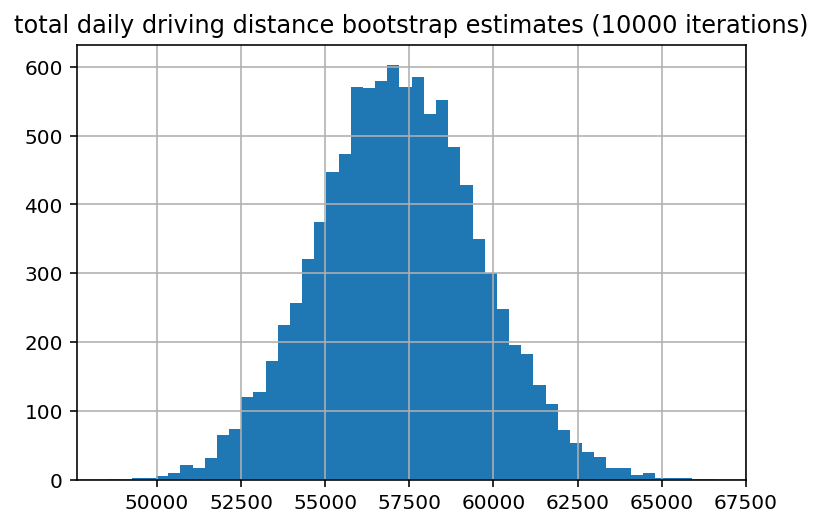

In [95]:
baseline_car_commuters_driving_dist_totals = baseline_car_commuters_driving_dist.sum()
baseline_car_commuters_driving_dist_totals.hist(bins=50)
plt.title('total daily driving distance bootstrap estimates (%s iterations)' % bs_iter)
print('mean = %0.2f' % baseline_car_commuters_driving_dist_totals.mean())
# create 95% confidence interval for population
ci = stats.norm.interval(alpha=0.95,
                 loc=np.mean(baseline_car_commuters_driving_dist_totals), 
                 scale=stats.sem(baseline_car_commuters_driving_dist_totals))
print('95%% CI [%0.2f, %0.2f]' % ci)
ci

### Baseline estimates by group

#### Computing driiving distance estimates by distance bucket:

In [96]:
# grouped and transposed: columns are distance buckets, rows are samples
by_dist_transpose =  baseline_car_commuters_driving_dist.reset_index().groupby(
    ['distance bucket int']
).sum().transpose()
by_dist_transpose.head()

distance bucket int          0           1           2            3   \
0                    154.797537  421.057652  578.669979  1415.814008   
1                    126.443001  411.225614  757.004548  1309.726095   
2                    111.840052  379.959073  708.736383  1303.629287   
3                    114.499597  391.693181  827.523529  1442.144345   
4                    105.722648  273.685064  783.133027  1366.155153   

distance bucket int           4            5            6            7   \
0                    2597.003942  2804.177724  2325.213555  2510.524161   
1                    2280.637567  2818.338385  2291.427247  3251.880756   
2                    1584.697068  2885.129124  2635.292252  3450.334041   
3                    1513.688175  3157.739319  2431.167905  2741.499623   
4                    2488.986562  3583.577643  2425.262592  3025.244942   

distance bucket int           8            9   ...           16           17  \
0                    2308.548105  3193.775310  ...  1833.286888  1316.181562   
1                    2774.090288  2503.951505  ...  1384.871535  1807.855962   
2                    2001.410552  2985.098676  ...  1900.868848  1077.527430   
3                    1839.199690  2776.387315  ...  1796.171506  1872.633223   
4                    2197.509989  3047.556308  ...  2110.137561  1747.864816   

distance bucket int           18           19           20           21  \
0                    3160.271935  2641.214276  1176.972542  1571.003925   
1                    2798.136280  1355.734669  1501.204988  1328.469014   
2                    2954.463485  2134.436944  1107.803019  1257.500605   
3                    1794.173632  2135.357937   750.320121   892.525535   
4                    2053.102743  2105.400301  1276.923110  1704.335747   

distance bucket int           22           23           24            25  
0                    2005.318555  1770.322618   790.078598  16766.469757  
1                    1466.252989   330.146275  1178.659925  17244.407617  
2                    1920.891040   820.363686  1453.123432  14148.519937  
3                    2216.732108   797.324767  1175.570470  15051.256353  
4                    2082.138849   680.834846  1462.693280  13381.935059  

[5 rows x 26 columns]

In [98]:
# make table:
# distance bucket, mean, 95% CI

data = {}
for bucket in by_dist_transpose.columns:
    data[bucket] = [
        round(np.mean(by_dist_transpose[bucket]), 2),  
        tuple(round(c, 2) for c in stats.norm.interval(alpha=0.95, 
                         loc=np.mean(by_dist_transpose[bucket]), 
                         scale=stats.sem(by_dist_transpose[bucket]))),
    ]
baseline_car_commuters_driving_dist_by_dist = pd.DataFrame(data).transpose()
baseline_car_commuters_driving_dist_by_dist.columns = ['mean', '95% CI']
baseline_car_commuters_driving_dist_by_dist['distance bucket label'] = \
    baseline_car_commuters_driving_dist_by_dist.index.map(lambda x: distance_bucket_labels[x])
# reorder columns 
baseline_car_commuters_driving_dist_by_dist = baseline_car_commuters_driving_dist_by_dist[
    ['distance bucket label','mean', '95% CI']
]
baseline_car_commuters_driving_dist_by_dist['% total'] = (
    100 * baseline_car_commuters_driving_dist_by_dist['mean']/baseline_car_commuters_driving_dist_by_dist['mean'].sum()
).apply(lambda x: round(x,2))
baseline_car_commuters_driving_dist_by_dist

distance bucket label      mean                95% CI  % total
0               < 1 mile    133.47      (133.02, 133.93)     0.23
1            1 - 2 miles    361.96      (361.04, 362.89)     0.63
2            2 - 3 miles    802.43       (800.8, 804.05)     1.40
3            3 - 4 miles   1329.06    (1325.83, 1332.29)     2.32
4            4 - 5 miles   2017.26     (2011.02, 2023.5)     3.53
5            5 - 6 miles   2911.20    (2905.44, 2916.95)     5.09
6            6 - 7 miles   2432.85    (2428.24, 2437.46)     4.25
7            7 - 8 miles   2934.60    (2927.63, 2941.56)     5.13
8            8 - 9 miles   2345.15    (2338.68, 2351.62)     4.10
9           9 - 10 miles   2701.60    (2694.82, 2708.37)     4.72
10         10 - 11 miles   1058.48    (1054.28, 1062.69)     1.85
11         11 - 12 miles   1723.48    (1717.49, 1729.47)     3.01
12         12 - 13 miles   1761.30    (1753.96, 1768.64)     3.08
13         13 - 14 miles   2328.06    (2319.14, 2336.98)     4.07
14         14 - 15 miles   1829.15     (1815.2, 1843.09)     3.20
15         15 - 16 miles   1872.66    (1860.87, 1884.44)     3.27
16         16 - 17 miles   1773.26    (1766.67, 1779.86)     3.10
17         17 - 18 miles   1580.04    (1574.65, 1585.43)     2.76
18         18 - 19 miles   2251.20    (2239.54, 2262.86)     3.94
19         19 - 20 miles   1740.94    (1732.69, 1749.18)     3.04
20         20 - 21 miles   1137.05    (1131.45, 1142.65)     1.99
21         21 - 22 miles   1342.85    (1336.79, 1348.91)     2.35
22         22 - 23 miles   1947.80    (1939.54, 1956.07)     3.41
23         23 - 24 miles   1066.23    (1059.53, 1072.93)     1.86
24         24 - 25 miles   1143.24    (1136.53, 1149.96)     2.00
25            > 25 miles  14676.94  (14644.52, 14709.36)    25.66

In [102]:
mean_distances = baseline_car_commuters_driving_dist_by_dist['mean']
fig, ax = plt.subplots(1, figsize=(10,5), dpi=600)
ax.bar(
    distance_bucket_labels,
    mean_distances, 
    yerr=[
        mean_distances - baseline_car_commuters_driving_dist_by_dist['95% CI'].apply(lambda x: x[0]),
        baseline_car_commuters_driving_dist_by_dist['95% CI'].apply(lambda x: x[1]) - mean_distances,
    ],
    color=c_car_commuters,
)
ax.set_ylabel('Daily miles driven by car commuters')
# _ = ax.set_title('Estimated daily miles driven by MIT car commuters by their residential distance from MIT')
_ = plt.xticks(rotation=90)

#### Computing driving estimates by academic group:

In [103]:
# grouped and transposed: columns are academic groups, rows are samples
by_academic_group_transpose =  baseline_car_commuters_driving_dist.reset_index().drop('distance bucket int', axis=1).groupby(
    ['TYPE_NUM']
).sum().transpose()
by_academic_group_transpose.head()

TYPE_NUM  Administrative Staff      Faculty  Graduate Student  \
0                 23868.819148  3979.748301       1226.766401   
1                 25435.953198  4182.725575       1674.526053   
2                 22329.302060  4576.715582       2026.606320   
3                 23796.100764  3894.716977        724.447849   
4                 22685.811182  3735.281185       1689.025335   

TYPE_NUM  Other Academic Group  Service Staff  Sponsored Research Staff  \
0                  4600.938951   16168.425005               4928.476517   
1                  5175.397995    8399.843568               6022.361925   
2                  5841.420595    8946.092604               7030.039892   
3                  6020.958055    8679.844969               6235.071142   
4                  5410.070812   10884.752797               6019.016495   

TYPE_NUM  Support Staff  Undergraduate Student  
0           6625.668597              80.830106  
1           6950.240822              41.799528  
2           6275.591266              95.437851  
3           5510.605451             205.412296  
4           7156.071794              72.603876

In [105]:
# make table:
# distance bucket, mean, 95% CI
data = {}
for g in by_academic_group_transpose.columns:
    data[g] = [
        round(np.mean(by_academic_group_transpose[g]), 2),  
        tuple(round(c, 2) for c in stats.norm.interval(alpha=0.95, 
                         loc=np.mean(by_academic_group_transpose[g]), 
                         scale=stats.sem(by_academic_group_transpose[g]))),
    ]
baseline_driving_dist_by_academic_g = pd.DataFrame(data).transpose().reindex(group_order) # set order
baseline_driving_dist_by_academic_g.columns = ['mean', '95% CI']
print('Driving distances by academic group (estimated by bootstrap with %s iterations)' % bs_iter)
baseline_driving_dist_by_academic_g

Driving distances by academic group (estimated by bootstrap with 10000 iterations)


mean                95% CI
Administrative Staff      22625.35  (22604.18, 22646.51)
Service Staff             10641.02  (10607.82, 10674.22)
Support Staff              6542.18     (6530.2, 6554.16)
Sponsored Research Staff   5996.36    (5984.16, 6008.55)
Other Academic Group       5339.73    (5326.47, 5352.99)
Faculty                    4357.62    (4346.16, 4369.08)
Graduate Student           1602.55    (1590.53, 1614.56)
Undergraduate Student        97.44         (96.3, 98.59)

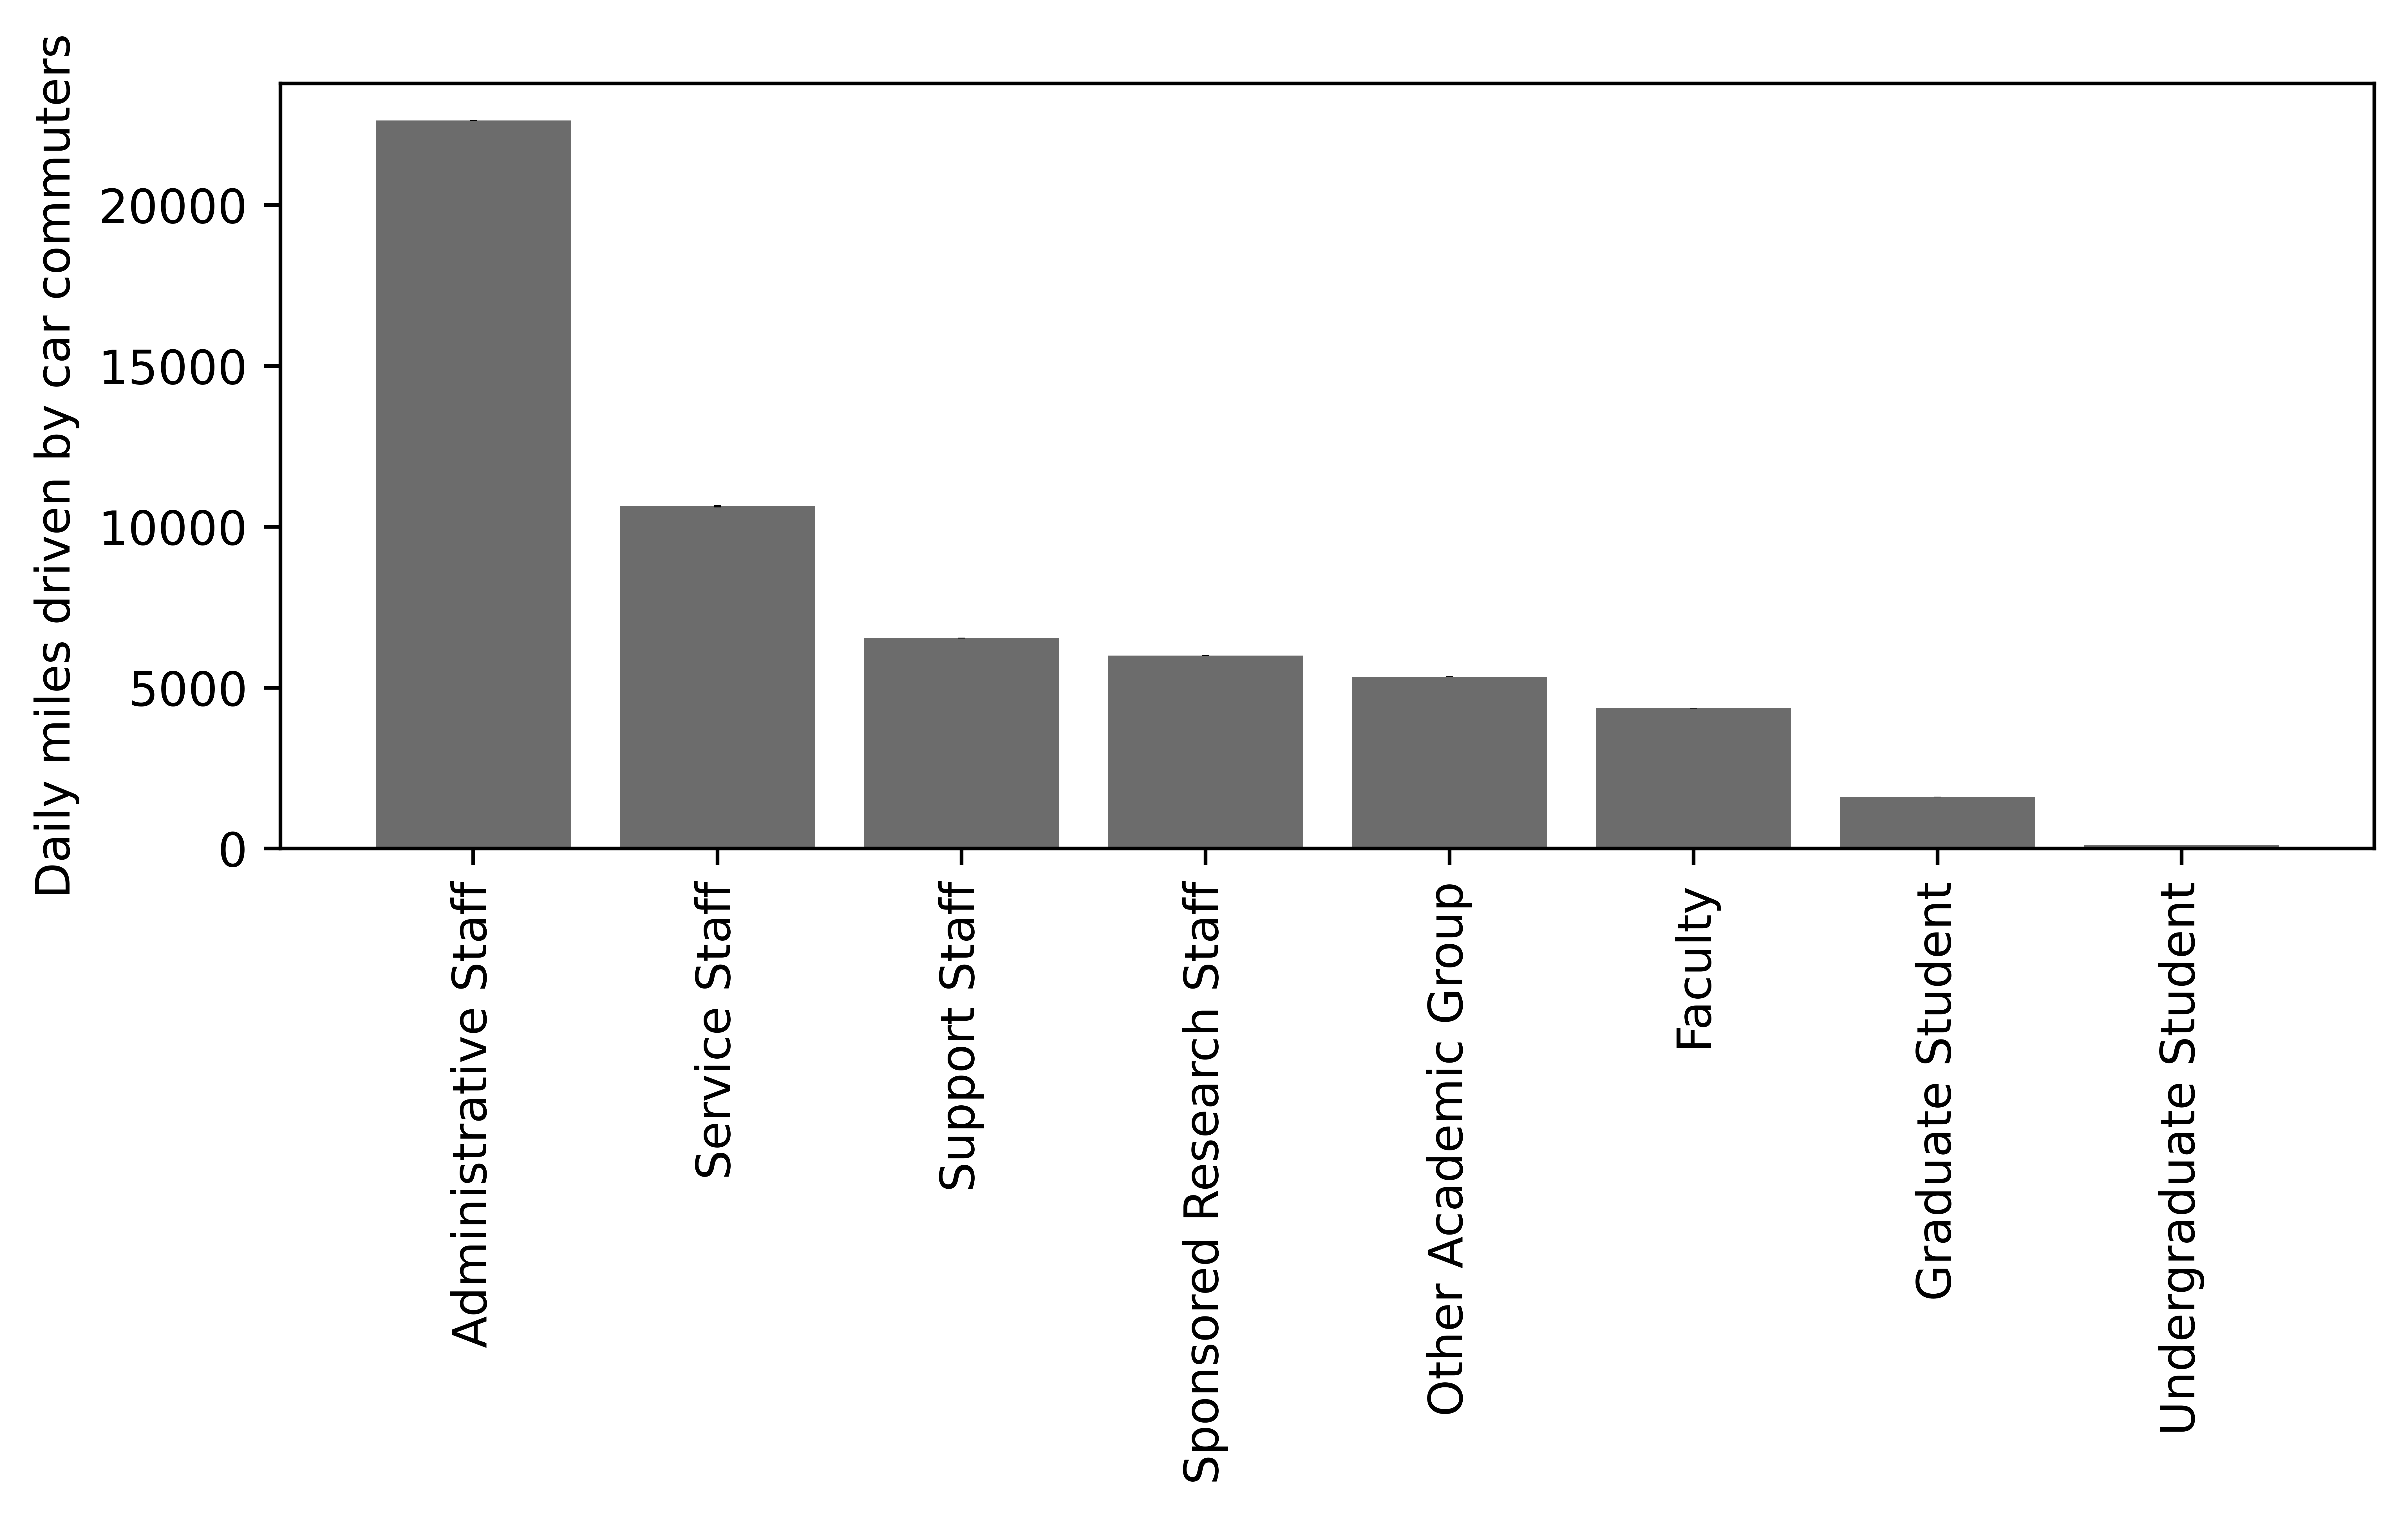

In [107]:
mean_distances = baseline_driving_dist_by_academic_g['mean']
fig, ax = plt.subplots(1, figsize=(8,3), dpi=600)
ax.bar(
    baseline_driving_dist_by_academic_g.index,
    mean_distances, 
    yerr=[
        mean_distances - baseline_driving_dist_by_academic_g['95% CI'].apply(lambda x: x[0]),
        baseline_driving_dist_by_academic_g['95% CI'].apply(lambda x: x[1]) - mean_distances,
    ],
    color=c_car_commuters,
)
ax.set_ylabel('Daily miles driven by car commuters')
# _ = ax.set_title('Estimated daily miles driven by MIT car commuters')
_ = plt.xticks(rotation=90)

#### Computing car commuter estimates by academic  group

In [109]:
# grouped and transposed: columns are academic groups, rows are samples
by_academic_group_transpose =  baseline_car_commuters.reset_index().drop('distance bucket int', axis=1).groupby(
    ['TYPE_NUM']
).sum().transpose()
# make table:
# distance bucket, mean, 95% CI
data = {}
for g in by_academic_group_transpose.columns:
    data[g] = [
        round(np.mean(by_academic_group_transpose[g]), 2),  
        tuple(round(c, 2) for c in stats.norm.interval(alpha=0.95, 
                         loc=np.mean(by_academic_group_transpose[g]), 
                         scale=stats.sem(by_academic_group_transpose[g]))),
    ]
baseline_car_commuters_by_academic_g = pd.DataFrame(data).transpose().reindex(group_order) # set order
baseline_car_commuters_by_academic_g.columns = ['mean', '95% CI']
print('Car commuters by academic group (estimated by bootstrap with %s iterations)' % bs_iter)
baseline_car_commuters_by_academic_g

Car commuters by academic group (estimated by bootstrap with 10000 iterations)


mean            95% CI
Administrative Staff      793.77  (793.19, 794.35)
Service Staff             318.47  (317.48, 319.46)
Support Staff             253.20  (252.84, 253.55)
Sponsored Research Staff  215.11  (214.78, 215.44)
Other Academic Group      242.16  (241.73, 242.59)
Faculty                   237.09  (236.68, 237.49)
Graduate Student           67.56     (67.32, 67.8)
Undergraduate Student      18.74    (18.61, 18.86)

### Comparison Table by Academic Group

Make a table to compare impacts of different academic groups with columns:

```

academic group, N, % total population, Estimated Daily Car commuters, % total car commuters, estimated daily miles driven for car commutes, % total daily miles driven


```

In [110]:
compare_academic_groups = partitions.reset_index().rename(
    columns={'TYPE_NUM':'Academic group'}
).groupby('Academic group').sum()['N'].to_frame().reindex(group_order)


total_N = compare_academic_groups['N'].sum()
#compare_academic_groups.loc['All','N'] = total_N
compare_academic_groups['N'] = compare_academic_groups['N'].astype(int)
compare_academic_groups['% total population'] = round(100*compare_academic_groups['N']/total_N,2)

compare_academic_groups['daily car commuters'] = baseline_car_commuters_by_academic_g['mean'].apply(round)
compare_academic_groups['daily car commuters 95% CI'] = baseline_car_commuters_by_academic_g['95% CI']
compare_academic_groups['% total daily car commuters'] = (
    100 * compare_academic_groups['daily car commuters'] / compare_academic_groups['daily car commuters'].sum()
).apply(lambda x: round(x, 2))

compare_academic_groups['daily miles driven for car commutes'] = baseline_driving_dist_by_academic_g['mean']
compare_academic_groups['daily miles driven for car commutes 95% CI'] = baseline_driving_dist_by_academic_g['95% CI']
compare_academic_groups['% total daily miles driven for car commutes'] = (
    100 * compare_academic_groups['daily miles driven for car commutes']/compare_academic_groups['daily miles driven for car commutes'].sum()
).apply(lambda x: round(x, 2))

print('Estimated values by academic group. Estimates and CIs computed with bootstrap sampling (%s iterations)' % bs_iter)
compare_academic_groups

Estimated values by academic group. Estimates and CIs computed with bootstrap sampling (10000 iterations)


N  % total population  daily car commuters  \
Academic group                                                            
Administrative Staff      2719               13.54                  794   
Service Staff              691                3.44                  318   
Support Staff             1391                6.93                  253   
Sponsored Research Staff  1494                7.44                  215   
Other Academic Group      2196               10.94                  242   
Faculty                    998                4.97                  237   
Graduate Student          6187               30.82                   68   
Undergraduate Student     4401               21.92                   19   

                         daily car commuters 95% CI  \
Academic group                                        
Administrative Staff               (793.19, 794.35)   
Service Staff                      (317.48, 319.46)   
Support Staff                      (252.84, 253.55)   
Sponsored Research Staff           (214.78, 215.44)   
Other Academic Group               (241.73, 242.59)   
Faculty                            (236.68, 237.49)   
Graduate Student                      (67.32, 67.8)   
Undergraduate Student                (18.61, 18.86)   

                          % total daily car commuters  \
Academic group                                          
Administrative Staff                            37.00   
Service Staff                                   14.82   
Support Staff                                   11.79   
Sponsored Research Staff                        10.02   
Other Academic Group                            11.28   
Faculty                                         11.04   
Graduate Student                                 3.17   
Undergraduate Student                            0.89   

                         daily miles driven for car commutes  \
Academic group                                                 
Administrative Staff                                22625.35   
Service Staff                                       10641.02   
Support Staff                                        6542.18   
Sponsored Research Staff                             5996.36   
Other Academic Group                                 5339.73   
Faculty                                              4357.62   
Graduate Student                                     1602.55   
Undergraduate Student                                  97.44   

                         daily miles driven for car commutes 95% CI  \
Academic group                                                        
Administrative Staff                           (22604.18, 22646.51)   
Service Staff                                  (10607.82, 10674.22)   
Support Staff                                     (6530.2, 6554.16)   
Sponsored Research Staff                         (5984.16, 6008.55)   
Other Academic Group                             (5326.47, 5352.99)   
Faculty                                          (4346.16, 4369.08)   
Graduate Student                                 (1590.53, 1614.56)   
Undergraduate Student                                 (96.3, 98.59)   

                          % total daily miles driven for car commutes  
Academic group                                                         
Administrative Staff                                            39.55  
Service Staff                                                   18.60  
Support Staff                                                   11.44  
Sponsored Research Staff                                        10.48  
Other Academic Group                                             9.33  
Faculty                                                          7.62  
Graduate Student                                                 2.80  
Undergraduate Student                                            0.17

In [ ]:
import re

def roundedCI(ci):
    l, u  = re.split(', |\(|\)', str(ci))[1:3]
    return '[%s, %s]'%(round(float(l)),round(float(u)))

pp =  pd.DataFrame({
    'N':compare_academic_groups['N'],
    '% population': compare_academic_groups['% total population'].apply(lambda s: str(s) + ' %'),
    'car commuters':compare_academic_groups['daily car commuters'],
    '% total car commuters': compare_academic_groups['% total daily car commuters'].apply(lambda s: str(s) + ' %'),
    'car commute miles': compare_academic_groups['daily miles driven for car commutes'].apply(round),
    '% total car commute miles': compare_academic_groups['% total daily miles driven for car commutes'].apply(lambda s: str(s) + ' %'),
},index=compare_academic_groups.index)
print(tabulate(pp, tablefmt='latex',headers='keys'))

In [113]:
fig, ax = plt.subplots(1, figsize=(6,8), dpi=600)
ax.barh(
    compare_academic_groups.index,
    compare_academic_groups['N'],
    alpha=0.4,
    label='All',
    color=c_non_car_commuters,
)
ax.barh(
    compare_academic_groups.index,
    compare_academic_groups['daily car commuters'],
    label='Car commuters',
    color=c_car_commuters,
)
_ = ax.set_title('Estimated car commuters by academic group')
ax.legend()
_ = plt.show()

## Estimate the number of on-campus parking users

The above estimated  MIT car commuters who use parking only counts the people who  are *driving  to campus*. It does not count the number  of people who  live on campus and use parking.

On-campus parking + car commuters parking should add up to daily parking transactions data.

Some number of the on-campus MIT community uses parking...

In [116]:
non_undergrads_on_campus = survey18_df[
    (survey18_df['OffCampus'] == 'On-campus') & \
    (survey18_df['TYPE_NUM'] != 'Undergraduate Student')
]
n_non_undergrads_on_campus = len(non_undergrads_on_campus)
print('N non-undergraduate on-campus residents = %s' %  n_non_undergrads_on_campus)

N non-undergraduate on-campus residents = 2320


Check the average number (and distribution)  of   autos for on campus graduate student and staff residents.

In [119]:
print('Q: Autos:')
survey18_codebook.loc['Autos']['Label'][0]

Q: Autos:


'How many total motor vehicles are CURRENTLY registered to members of your household?'

index  Autos
4     0  755.0
0     1  100.0
1     2    9.0
2     3    0.0
5     4    0.0
3    5+    5.0

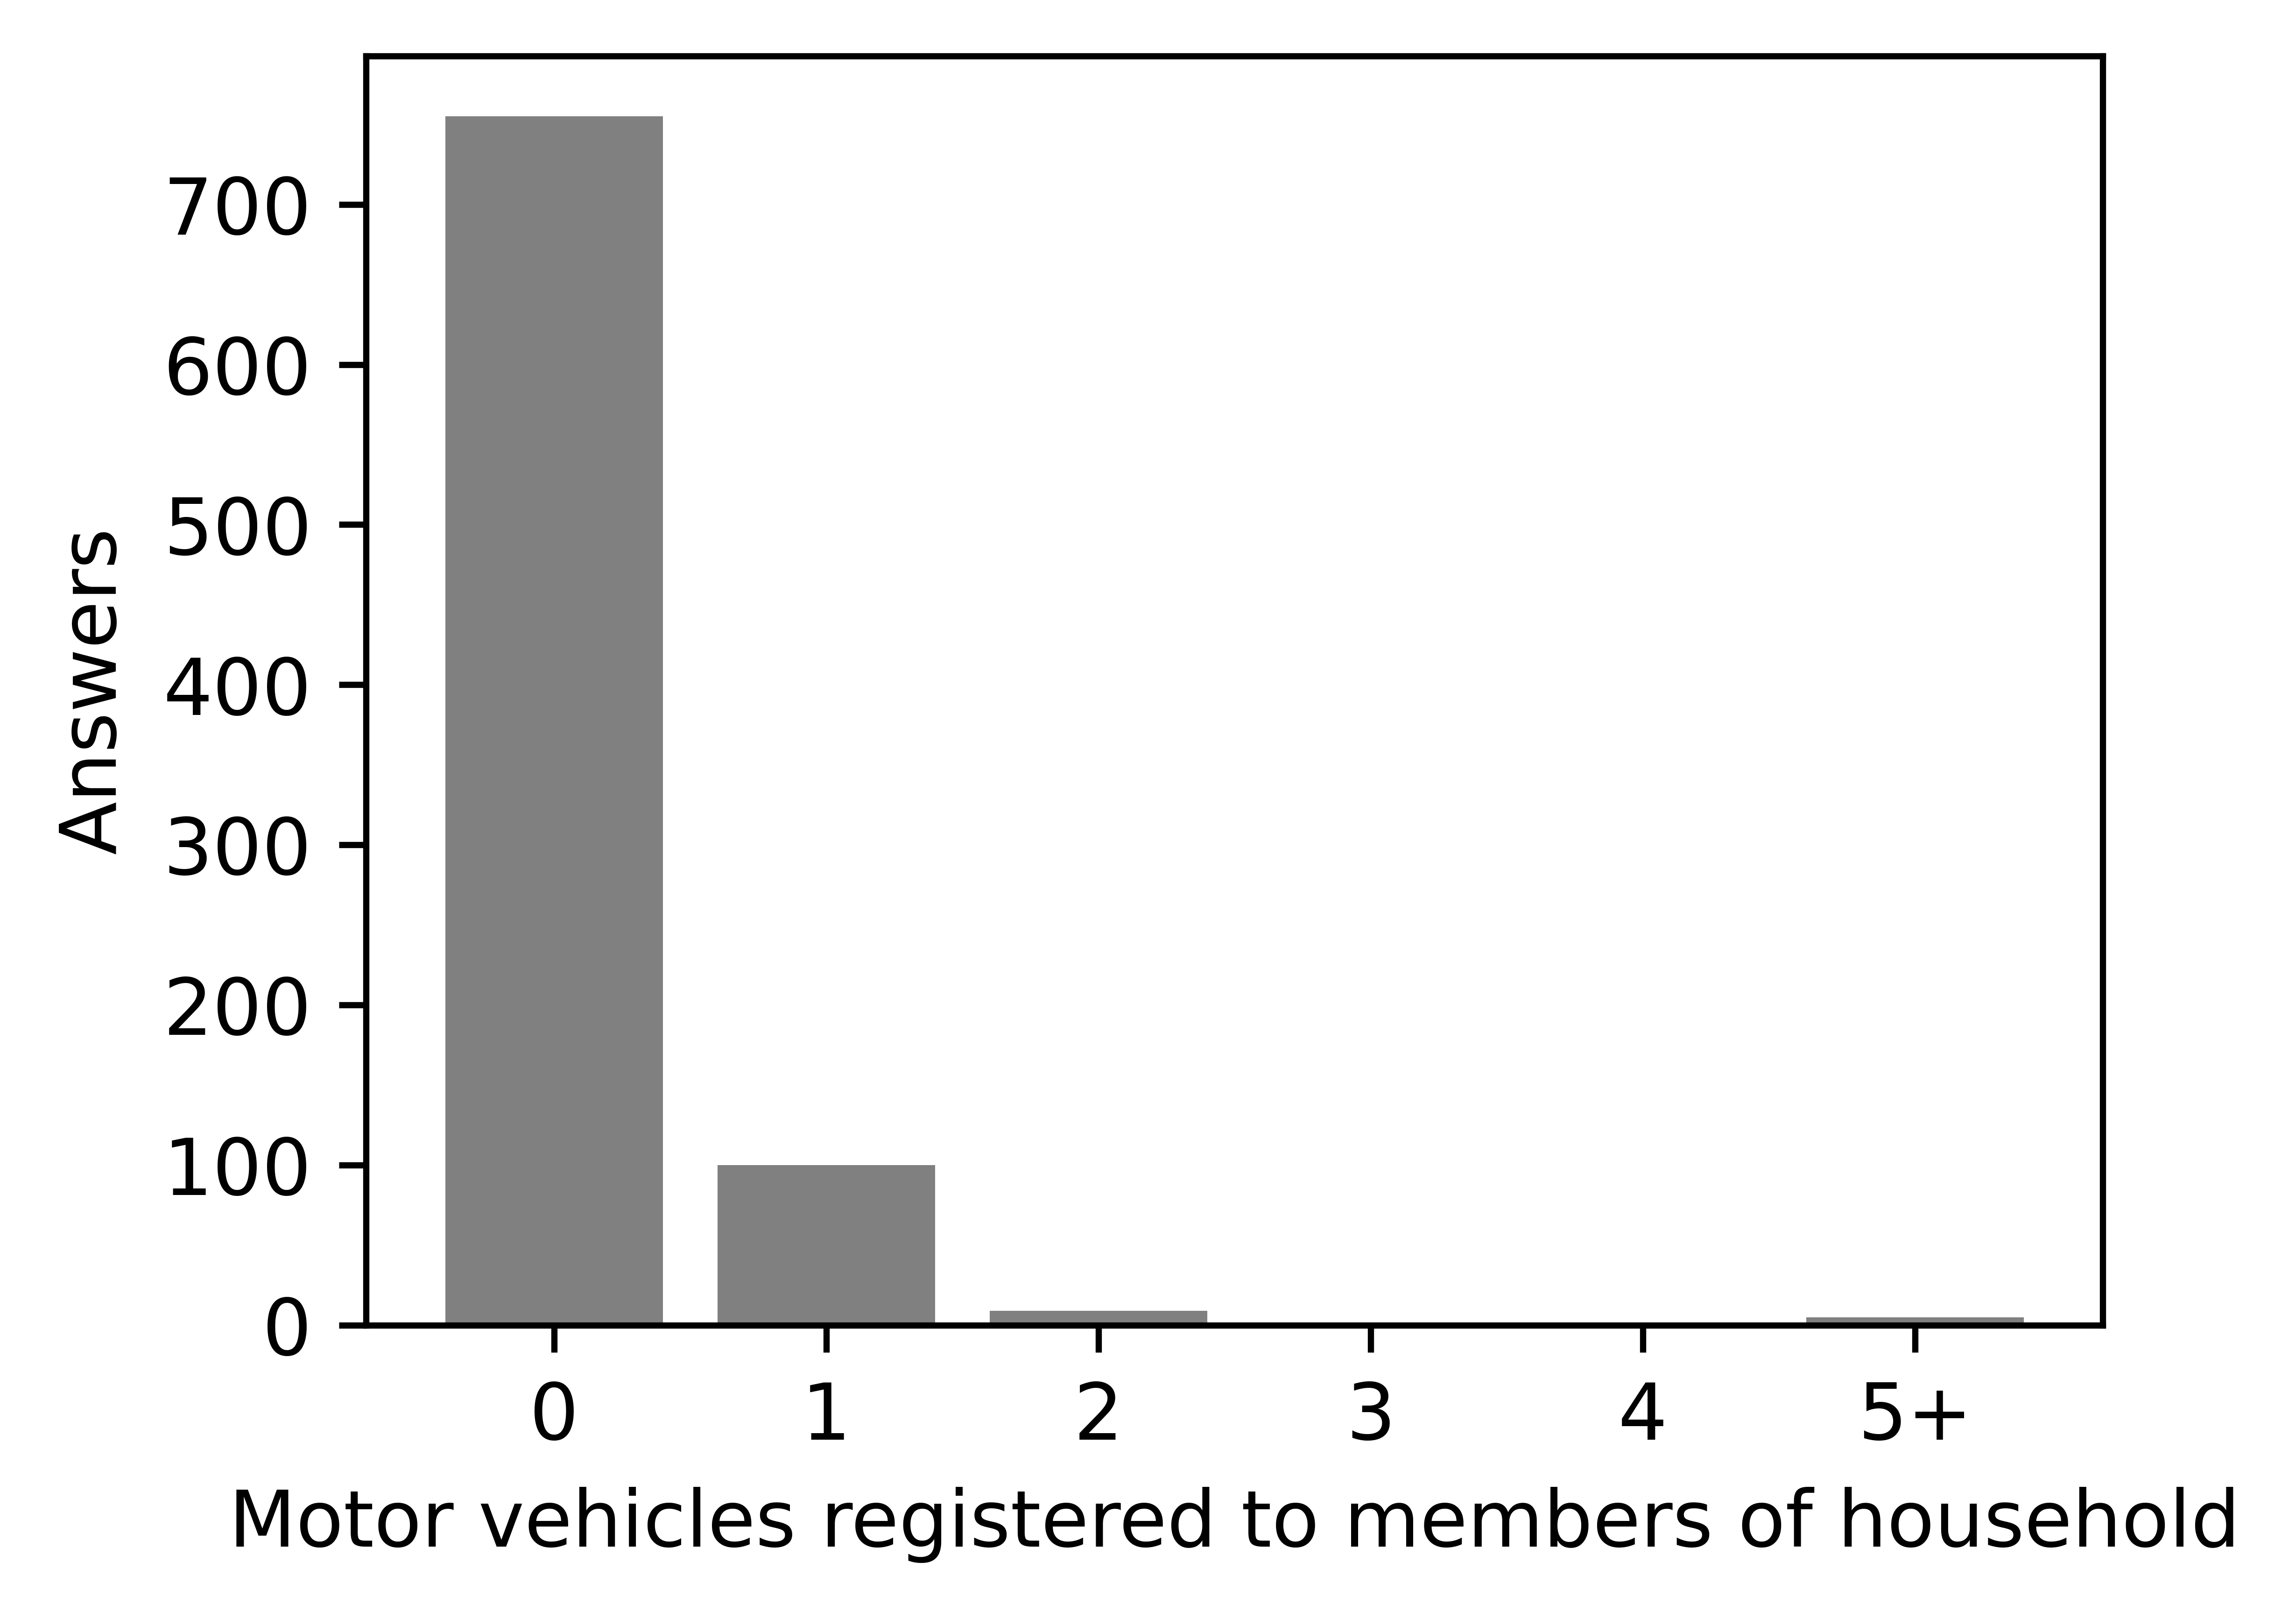

In [121]:
on_campus_autos = non_undergrads_on_campus['Autos'].value_counts().reindex(
    survey18_df['Autos'].dropna().unique()
).fillna(0).to_frame().reset_index().sort_values('index')
fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=600)
ax.bar(on_campus_autos['index'], on_campus_autos['Autos'],color='gray')
ax.set_ylabel('Answers')
ax.set_xlabel('Motor vehicles registered to members of household')
on_campus_autos

Consider the 5+ answers as 5. Compute the mean from the other answers.

In [804]:
mean_on_campus_autos = on_campus_autos.dropna().apply(lambda x: x.replace('+','')).astype(int).mean()
print('mean autos on-campus = %0.3f' % mean_on_campus_autos)
print('(N non-undergrad on-campus residents) x (mean on-campus autos) = %s x %0.3f = %0.3f' % (
    n_non_undergrads_on_campus, mean_on_campus_autos, n_non_undergrads_on_campus*mean_on_campus_autos
))

mean autos on-campus = 0.165
(N non-undergrad on-campus residents) x (mean on-campus autos) = 2320 x 0.165 = 381.772


The daily estimated MIT car commuters parking (weighted by day) closely matches the parking transactions data.

## Comparing Scenarios

In [624]:
sample_partitioned = sample.groupby(
    ['TYPE_NUM', 'distance bucket int']
).sum()[['car commuter', 'car commuter parking', DRIVING_DISTANCE_WEIGHT]]
sample_partitioned.head(3)

car commuter  car commuter parking  \
TYPE_NUM             distance bucket int                                       
Administrative Staff 0                             7.4                   3.6   
                     1                            17.8                  12.2   
                     2                            31.0                  25.8   

                                          driving distance weight  
TYPE_NUM             distance bucket int                           
Administrative Staff 0                                  16.390872  
                     1                                  79.490550  
                     2                                 199.648714

In [626]:
baseline_partitioned = sample_partitioned.apply(lambda x: x.multiply(partitions['weight']))
baseline_partitioned.head(3)

car commuter  car commuter parking  \
TYPE_NUM             distance bucket int                                       
Administrative Staff 0                       10.038261              4.883478   
                     1                       25.535079             17.501571   
                     2                       40.428571             33.647005   

                                          driving distance weight  
TYPE_NUM             distance bucket int                           
Administrative Staff 0                                  22.234574  
                     1                                 114.033565  
                     2                                 260.371365

For  each scenario, estimate the change from the baseline scenario  for

- daily car commuters
- daily car commuters using MIT parking facilities
- miles driven for car commutes (proxy for emissions)

In [617]:
def estimate_daily_car_commuters(partitioned_df):
    return partitioned_df['car commuter'].sum()

def estimate_daily_car_commuters_parking(partitioned_df):
    return partitioned_df['car commuter parking'].sum()

def estimate_daily_driving_dist_by_car_commuters(partitioned_df):
    return partitioned_df[DRIVING_DISTANCE_WEIGHT].sum()


def print_changes_from_baseline(scenario_partitioned, intervention_name="",
                                baseline_partitioned=baseline_partitioned):
    print('------------------------\nIntervention %s Results\n------------------------' \
          % intervention_name)    
    scenario_car_commuters = estimate_daily_car_commuters(scenario_partitioned)
    baseline_car_commuters = estimate_daily_car_commuters(baseline_partitioned)
    change_in_car_commuters = scenario_car_commuters - baseline_car_commuters
    print('estimated change in daily car commuters: %0.0f' % change_in_car_commuters)
    scenario_parking = estimate_daily_car_commuters_parking(scenario_partitioned)
    baseline_parking = estimate_daily_car_commuters_parking(baseline_partitioned)
    change_in_parking = scenario_parking - baseline_parking
    print('estimated change in daily car commuters using MIT parking facilities: %0.0f' % change_in_parking)
    baseline_driving_dist = estimate_daily_driving_dist_by_car_commuters(baseline_partitioned)
    scenario_driving_dist = estimate_daily_driving_dist_by_car_commuters(scenario_partitioned)
    relative_change_driving_dist = (scenario_driving_dist - baseline_driving_dist)/baseline_driving_dist
    print('estimated change in distance driven by car commutes: %0.1f%%' % (100*relative_change_driving_dist))
    
    
print_changes_from_baseline(baseline_partitioned, intervention_name='0')

------------------------
Intervention 0 Results
------------------------
estimated change in daily car commuters: 0
estimated change in daily car commuters using MIT parking facilities: 0
estimated change in distance driven by car commutes: 0.0%


### Intervention A.1: A random 20% of staff (excluding service staff) stays home each day


The types included in the intervention:
```
Support Staff
Administrative Staff
Sponsored Research Staff
Other Academic Group
Faculty
```

The number of people kept home is proportional across academic groups type x distance.


In [630]:
non_service_staff = [
    'Administrative Staff', 
    'Faculty',
    'Other Academic Group', 
    #'Service Staff', 
    'Sponsored Research Staff', 
    'Support Staff'
]
interventionA1_types = non_service_staff
A1_weights = partitions.index.map(lambda x: 0.8 if x[0] in interventionA1_types else 1) * partitions['weight']
scenarioA1_partitioned = sample_partitioned.apply(lambda x: x.multiply(A1_weights))
print_changes_from_baseline(scenarioA1_partitioned, intervention_name='A.1')
scenarioA1_partitioned.head()

------------------------
Intervention A.1 Results
------------------------
estimated change in daily car commuters: -349
estimated change in daily car commuters using MIT parking facilities: -296
estimated change in distance driven by car commutes: -15.6%


car commuter  car commuter parking  \
TYPE_NUM             distance bucket int                                       
Administrative Staff 0                        8.030609              3.906783   
                     1                       20.428063             14.001257   
                     2                       32.342857             26.917604   
                     3                       33.234404             24.977409   
                     4                       42.466667             38.328889   

                                          driving distance weight  
TYPE_NUM             distance bucket int                           
Administrative Staff 0                                  17.787660  
                     1                                  91.226852  
                     2                                 208.297092  
                     3                                 301.963106  
                     4                                 478.022632

### Intervention A.2 : 20% of administrative staff stays home

What if 20% of just the administrative staff stayed home each day?

In [621]:
interventionA2_types = ['Administrative Staff']
A2_weights = partitions.index.map(lambda x: 0.8 if x[0] in interventionA2_types else 1) * partitions['weight']
scenarioA2_partitioned = sample_partitioned.apply(lambda x: x.multiply(A2_weights))
print_changes_from_baseline(scenarioA2_partitioned, intervention_name='A.2')
scenarioA2_partitioned.head()

------------------------
Intervention A.2 Results
------------------------
estimated change in daily car commuters: -159
estimated change in daily car commuters using MIT parking facilities: -131
estimated change in distance driven by car commutes: -7.8%


car commuter  car commuter parking  \
TYPE_NUM             distance bucket int                                       
Administrative Staff 0                        8.030609              3.906783   
                     1                       20.428063             14.001257   
                     2                       32.342857             26.917604   
                     3                       33.234404             24.977409   
                     4                       42.466667             38.328889   

                                          driving distance weight  
TYPE_NUM             distance bucket int                           
Administrative Staff 0                                  17.787660  
                     1                                  91.226852  
                     2                                 208.297092  
                     3                                 301.963106  
                     4                                 478.022632

### Intervention A.3 : 40% of administrative staff stays home

What if 40% of just the administrative staff stayed home each day?

In [622]:
interventionA3_types = ['Administrative Staff']
A3_weights = partitions.index.map(lambda x: 0.6 if x[0] in interventionA3_types else 1) * partitions['weight']
scenarioA3_partitioned = sample_partitioned.apply(lambda x: x.multiply(A3_weights))
print_changes_from_baseline(scenarioA3_partitioned, intervention_name='A.3')
scenarioA3_partitioned.head()

------------------------
Intervention A.3 Results
------------------------
estimated change in daily car commuters: -318
estimated change in daily car commuters using MIT parking facilities: -263
estimated change in distance driven by car commutes: -15.7%


car commuter  car commuter parking  \
TYPE_NUM             distance bucket int                                       
Administrative Staff 0                        6.022957              2.930087   
                     1                       15.321047             10.500942   
                     2                       24.257143             20.188203   
                     3                       24.925803             18.733057   
                     4                       31.850000             28.746667   

                                          driving distance weight  
TYPE_NUM             distance bucket int                           
Administrative Staff 0                                  13.340745  
                     1                                  68.420139  
                     2                                 156.222819  
                     3                                 226.472330  
                     4                                 358.516974

### Intervention B: 20% of the MIT car commuters who live within a 5 mile  radius switch to alternative commute  modes.

In [623]:
B_weights = partitions.index.map(lambda x: 0.8 if x[1] in [0,1,2,3,4] else 1) * partitions['weight']
scenarioB_partitioned = sample_partitioned.apply(lambda x: x.multiply(B_weights))
print_changes_from_baseline(scenarioB_partitioned, intervention_name='B')
scenarioB_partitioned.head()

------------------------
Intervention B Results
------------------------
estimated change in daily car commuters: -122
estimated change in daily car commuters using MIT parking facilities: -85
estimated change in distance driven by car commutes: -1.6%


car commuter  car commuter parking  \
TYPE_NUM             distance bucket int                                       
Administrative Staff 0                        8.030609              3.906783   
                     1                       20.428063             14.001257   
                     2                       32.342857             26.917604   
                     3                       33.234404             24.977409   
                     4                       42.466667             38.328889   

                                          driving distance weight  
TYPE_NUM             distance bucket int                           
Administrative Staff 0                                  17.787660  
                     1                                  91.226852  
                     2                                 208.297092  
                     3                                 301.963106  
                     4                                 478.022632

Results: 85 parking spaces could be freed up, but there is a negligible reduction in CO2 emissions.

## Intervention (A+B): Metrics

Intervention A1 is applied. 20% of the remaining MIT car commuters within a 5 mile radius of MIT switch to alternative transit.

In [629]:
AB_weights = partitions.index.map(lambda x: 0.8 if x[1] in [0,1,2,3,4] else 1) * A1_weights
scenarioAB_partitioned = sample_partitioned.apply(lambda x: x.multiply(AB_weights))
print_changes_from_baseline(scenarioAB_partitioned, intervention_name='A+B')
scenarioAB_partitioned.head()

------------------------
Intervention A+B Results
------------------------
estimated change in daily car commuters: -451
estimated change in daily car commuters using MIT parking facilities: -367
estimated change in distance driven by car commutes: -17.0%


car commuter  car commuter parking  \
TYPE_NUM             distance bucket int                                       
Administrative Staff 0                        6.424487              3.125426   
                     1                       16.342450             11.201005   
                     2                       25.874286             21.534083   
                     3                       26.587523             19.981927   
                     4                       33.973333             30.663111   

                                          driving distance weight  
TYPE_NUM             distance bucket int                           
Administrative Staff 0                                  14.230128  
                     1                                  72.981481  
                     2                                 166.637673  
                     3                                 241.570485  
                     4                                 382.418105

Additional parking spaces can be freed. There is a negligible additional reduction in CO2 emissions.

## Intervention C: Housing near campus for the MIT community

What if there was new housing supply within 1 mile of MIT for the MIT community?

What portion of the community currently lives within 1 mile of MIT? How do this compare to other distances from MIT?

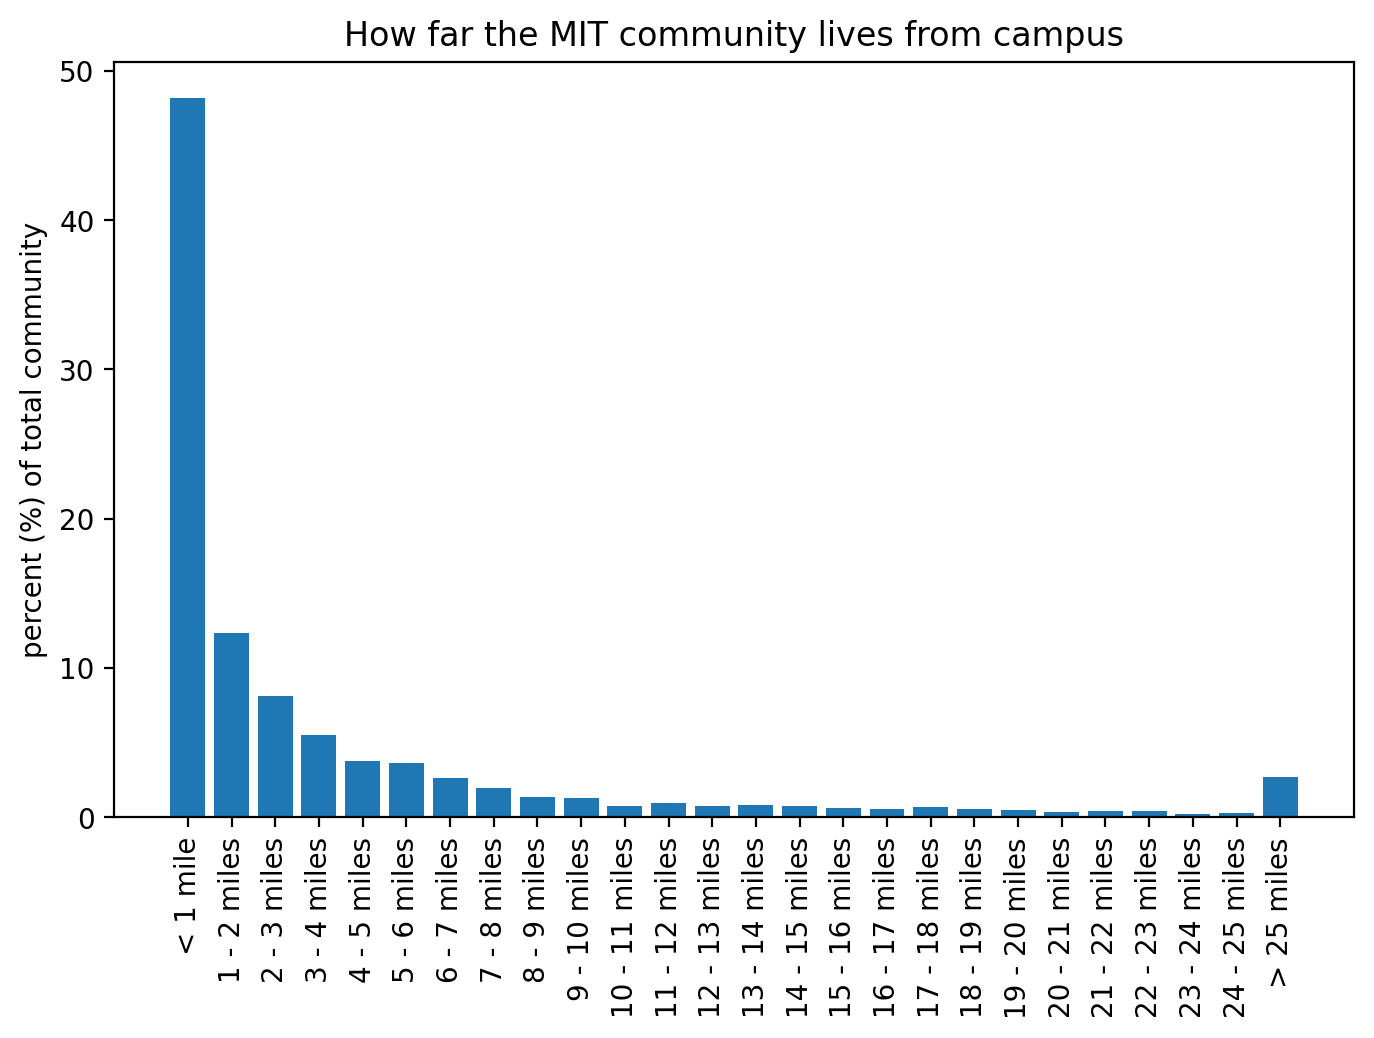

N  % of total community
distance bucket int                            
0                    9672             48.174528
1                    2475             12.327539
2                    1632              8.128704
3                    1104              5.498830
4                     756              3.765503

In [635]:
distances = partitions.reset_index().groupby(
    'distance bucket int'
).sum()['N'].to_frame()
distances['% of total community'] = 100 * distances['N']/distances['N'].sum()
fig, ax = plt.subplots(1, figsize=(8,5), dpi=100)
ax.bar(
    distance_bucket_labels,
    distances['% of total community'],
)
plt.xticks(rotation=90)
plt.title('How far the MIT community lives from campus')
plt.ylabel('percent (%) of total community')
plt.show()
distances.head()

## Intervention C: Housing is made available to increase the number of MIT community members living within 1 mile of MIT by 20%

48% of the MIT community lives within 1 mile from campus. That group has the smallest number of daily MIT car commuters.


In this intervention, 20% of the population in each academic group living more than 1 mile from campus moves to within 1 mile of campus. 
This is modeled  by recomputing the population partition sizes and weights.  
For each academic group, the population living any distance more than 1 mile from campus is decreased by a factor of 0.8. This decrease in population is then added to the population for that same academic group living within a 1 mile radius of campus.
It is then assumed that the rate  at which each academic group commutes by car will be the same as the group’s population previously living in the area.

In [692]:
C_partition_N_decreases = (0.2 * partitions['N']).to_frame()

C_partition_N_increases = C_partition_N_decreases['N'].reset_index().groupby('TYPE_NUM').sum()
C_partition_N_increases['distance bucket int'] = 0
C_partition_N_increases = C_partition_N_increases.reset_index().set_index(
    ['TYPE_NUM', 'distance bucket int']
).reindex(partitions.index).fillna(0)
#C_partition_N_increases.head()

In [697]:
C_partitions = (
    partitions['N'] - C_partition_N_decreases['N'] + C_partition_N_increases['N']
).to_frame()
# Assert the total and marginal population sums did not change
assert(int(C_partitions['N'].sum()) == int(partitions['N'].sum()))
for g in group_order:
    assert(round(C_partitions.loc[g,'N'].sum()) == round(partitions.loc[g,'N'].sum()))

C_partitions['n'] = partitions['n']
C_partitions['weight'] = C_partitions['N']/C_partitions['n']
C_partitions.head()

N      n    weight
TYPE_NUM             distance bucket int                        
Administrative Staff 0                    668.6  115.0  5.813913
                     1                    219.2  191.0  1.147644
                     2                    226.4  217.0  1.043318
                     3                    199.2  193.0  1.032124
                     4                    156.8  144.0  1.088889

In [700]:
scenarioC_partitioned = sample_partitioned.apply(lambda x: x.multiply(C_partitions['weight']))
print_changes_from_baseline(scenarioC_partitioned, intervention_name='C')
scenarioC_partitioned.head()

------------------------
Intervention C Results
------------------------
estimated change in daily car commuters: -357
estimated change in daily car commuters using MIT parking facilities: -315
estimated change in distance driven by car commutes: -19.7%


car commuter  car commuter parking  \
TYPE_NUM             distance bucket int                                       
Administrative Staff 0                       43.022957             20.930087   
                     1                       20.428063             14.001257   
                     2                       32.342857             26.917604   
                     3                       33.234404             24.977409   
                     4                       42.466667             38.328889   

                                          driving distance weight  
TYPE_NUM             distance bucket int                           
Administrative Staff 0                                  95.295106  
                     1                                  91.226852  
                     2                                 208.297092  
                     3                                 301.963106  
                     4                                 478.022632

## Intervention C.2: Housing is made available to increase the number of MIT community members living within 1 mile of MIT from 48% to 90%.

In this intervention, 42% of the people living more than 1 mile of MIT move to within 1 mile of MIT. This brings the total percentage of the MIT community living within 1 mile to 90%. People who move assume the commuting behaviors of their neighbors.

In [701]:
C2_partition_N_decreases = (0.42 * partitions['N']).to_frame()
C2_partition_N_increases = C2_partition_N_decreases['N'].reset_index().groupby('TYPE_NUM').sum()
C2_partition_N_increases['distance bucket int'] = 0
C2_partition_N_increases = C2_partition_N_increases.reset_index().set_index(
    ['TYPE_NUM', 'distance bucket int']
).reindex(partitions.index).fillna(0)

C2_partitions = (
    partitions['N'] - C2_partition_N_decreases['N'] + C2_partition_N_increases['N']
).to_frame()
# Assert the total and marginal population sums did not change
assert(int(C2_partitions['N'].sum()) == int(partitions['N'].sum()))
for g in group_order:
    assert(round(C2_partitions.loc[g,'N'].sum()) == round(partitions.loc[g,'N'].sum()))

C2_partitions['n'] = partitions['n']
C2_partitions['weight'] = C2_partitions['N']/C2_partitions['n']
C2_partitions.head()

N      n     weight
TYPE_NUM             distance bucket int                           
Administrative Staff 0                    1232.46  115.0  10.717043
                     1                     158.92  191.0   0.832042
                     2                     164.14  217.0   0.756406
                     3                     144.42  193.0   0.748290
                     4                     113.68  144.0   0.789444

In [702]:
scenarioC2_partitioned = sample_partitioned.apply(lambda x: x.multiply(C2_partitions['weight']))
print_changes_from_baseline(scenarioC2_partitioned, intervention_name='C.2')
scenarioC2_partitioned.head()

------------------------
Intervention C.2 Results
------------------------
estimated change in daily car commuters: -749
estimated change in daily car commuters using MIT parking facilities: -662
estimated change in distance driven by car commutes: -41.4%


car commuter  car commuter parking  \
TYPE_NUM             distance bucket int                                       
Administrative Staff 0                       79.306122             38.581357   
                     1                       14.810346             10.150911   
                     2                       23.448571             19.515263   
                     3                       24.094943             18.108622   
                     4                       30.788333             27.788444   

                                          driving distance weight  
TYPE_NUM             distance bucket int                           
Administrative Staff 0                                 175.661690  
                     1                                  66.139467  
                     2                                 151.015392  
                     3                                 218.923252  
                     4                                 346.566408

# More Plotting

What is the best way to show this data?

How far  car  commuters vs all live from MIT, by academic group.

In [122]:
IS_CAR_COMMUTER = 'is car commuter'
completions_df[IS_CAR_COMMUTER] = (completions_df[CAR_COMMUTER]>0.5)

In [135]:
import seaborn as sns
sns.set(rc={
    "figure.dpi":600, 'savefig.dpi':600,
    'axes.facecolor':'white', 'figure.facecolor':'white'
})
sns.set_context('notebook')

plt_df = completions_df[['TYPE_NUM', 'distance to MIT (miles)', IS_CAR_COMMUTER]].copy()
plt_df['Primary commute method'] = plt_df[IS_CAR_COMMUTER].map(
    {True: 'Car', False: 'All other modes'}
)
ax=sns.catplot(x='distance to MIT (miles)', y='TYPE_NUM',
               hue='Primary commute method',
               palette=sns.color_palette([c_non_car_commuters,c_car_commuters]),
               order=group_order[::-1],
               data=plt_df, kind="box", height=6, aspect=1.2)
_ = ax.set_ylabels('')
ax.fig.subplots_adjust(top=0.9)
_ = ax.fig.suptitle('Residential distance from campus by academic group and commute method')
plt.show()
plt_df.head(2)

TYPE_NUM  distance to MIT (miles)  is car commuter  \
1      Administrative Staff                 4.987506            False   
3  Sponsored Research Staff                 4.987506            False   

  Primary commute method  
1        All other modes  
3        All other modes

# Linear Regression

A simple linear regression to show that distance has a different impact on likelihood to drive for students versus staff.


Regressions are separately estimated for these two groups as follows.

The regression compares the distance of residential census block group to MIT (indepedent variable) versus the portion of the population residing in that block group that are car commuters. Respondents who answered that they commute by driving alone most days (i.e. have a car commuter weight >= 0.5) are considered car commuters.


The linear regression is described by the following equation that considers each residential census block, i.

$ \frac{car\_commuters_i}{population_i}  = constant + β \times distance_i$

Only residential census block groups  with more than 5 respondents are used in the analysis.

For analysis make aggregate tables:

```
GEOID, distance from MIT, N, car commuters
```

In [848]:
from scipy.stats import pearsonr
import statsmodels.api as sm

In [836]:
N = 'N'
PID = 'PID'
TYPE_NUM = 'TYPE_NUM'
DISTANCE_TO_MIT = 'distance to MIT (miles)'
PORTION_CAR_COMMUTERS = '𝑐𝑎𝑟_𝑐𝑜𝑚𝑚𝑢𝑡𝑒𝑟𝑠/𝑝𝑜𝑝𝑢𝑙𝑎𝑡𝑖𝑜𝑛'

def get_geoid_agg_df(df):
    agg_df = pd.DataFrame({
        N: df.groupby(
            GEOID
        )[PID].count(),
        CAR_COMMUTER: df.groupby(
            GEOID
        )[CAR_COMMUTER].sum(),
    }).reset_index().set_index(GEOID).merge(bg[[DISTANCE_TO_MIT]], on=GEOID)
    agg_df[PORTION_CAR_COMMUTERS] = agg_df[CAR_COMMUTER]/agg_df[N]
    return agg_df.sort_values(N, ascending=False)

In [840]:
student_geoids_agg_df = get_geoid_agg_df(completions_df[
    completions_df[TYPE_NUM].isin(['Graduate Student', 'Undergraduate Student'])
])
staff_geoids_agg_df = get_geoid_agg_df(completions_df[
    completions_df[TYPE_NUM].isin(
        ['Service Staff', 'Faculty', 'Sponsored Research Staff', 
         'Support Staff', 'Other Academic Group', 'Administrative Staff']
    )])
staff_geoids_agg_df.head(5)

N  car commuter  distance to MIT (miles)  \
GEOID                                                     
250173530004  43           0.0                 0.850527   
250173523001  32           0.2                 0.632736   
250173532001  31           0.6                 0.602097   
250173549003  30           4.2                 3.653581   
250173531022  29           0.0                 0.299545   

              𝑐𝑎𝑟_𝑐𝑜𝑚𝑚𝑢𝑡𝑒𝑟𝑠/𝑝𝑜𝑝𝑢𝑙𝑎𝑡𝑖𝑜𝑛  
GEOID                                   
250173530004                  0.000000  
250173523001                  0.006250  
250173532001                  0.019355  
250173549003                  0.140000  
250173531022                  0.000000

In [878]:
# restrict data to GEOIDs with N > 5
staff_agg_df5 = staff_geoids_agg_df[staff_geoids_agg_df[N]>5]
student_agg_df5 = student_geoids_agg_df[student_geoids_agg_df[N]>5]

print('Staff: N = %s total block groups and %s total respondents' \
      % (len(staff_agg_df5), staff_agg_df5[N].sum()))
print('Students: N = %s total block groups and %s total respondents' \
      % (len(student_agg_df5), student_agg_df5[N].sum()))

Staff: N = 206 total block groups and 2097 total respondents
Students: N = 83 total block groups and 3518 total respondents


In [872]:
staff_Y = staff_agg_df5[PORTION_CAR_COMMUTERS]
student_Y = student_agg_df5[PORTION_CAR_COMMUTERS]

staff_x = staff_agg_df5[DISTANCE_TO_MIT]
student_x = student_agg_df5[DISTANCE_TO_MIT]
# Pearson's Correlation Coefficient
stat, p = pearsonr(staff_Y, staff_x)
print('For staff data: The Pearson r correlation coefficient is %.3f, with a p-value of %.3f' %(stat, p))
stat, p = pearsonr(student_Y, student_x)
print('For student data: The Pearson r correlation coefficient is %.3f, with a p-value of %.3f' %(stat, p))

For staff data: The Pearson r correlation coefficient is 0.490, with a p-value of 0.000
For student data: The Pearson r correlation coefficient is 0.184, with a p-value of 0.095


In [873]:
staff_model_results = sm.OLS(staff_Y, sm.add_constant(staff_x)).fit()
staff_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     𝑐𝑎𝑟_𝑐𝑜𝑚𝑚𝑢𝑡𝑒𝑟𝑠/𝑝𝑜𝑝𝑢𝑙𝑎𝑡𝑖𝑜𝑛   R-squared:                       0.240
Model:                                  OLS   Adj. R-squared:                  0.237
Method:                       Least Squares   F-statistic:                     64.54
Date:                      Wed, 24 Mar 2021   Prob (F-statistic):           7.45e-14
Time:                              11:54:55   Log-Likelihood:                 133.82
No. Observations:                       206   AIC:                            -263.6
Df Residuals:                           204   BIC:                            -257.0
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0418      0.013      3.171      0.002       0.016       0.068
distance to MIT (miles)     0.0243      0.003      8.034      0.000       0.018       0.030
==============================================================================
Omnibus:                       32.733   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.194
Skew:                           0.741   Prob(JB):                     3.47e-16
Kurtosis:                       5.470   Cond. No.                         6.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [874]:
student_model_results = sm.OLS(student_Y, sm.add_constant(student_x)).fit()
student_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     𝑐𝑎𝑟_𝑐𝑜𝑚𝑚𝑢𝑡𝑒𝑟𝑠/𝑝𝑜𝑝𝑢𝑙𝑎𝑡𝑖𝑜𝑛   R-squared:                       0.034
Model:                                  OLS   Adj. R-squared:                  0.022
Method:                       Least Squares   F-statistic:                     2.854
Date:                      Wed, 24 Mar 2021   Prob (F-statistic):             0.0950
Time:                              11:54:55   Log-Likelihood:                 187.18
No. Observations:                        83   AIC:                            -370.4
Df Residuals:                            81   BIC:                            -365.5
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0009      0.006     -0.157      0.875      -0.012       0.010
distance to MIT (miles)     0.0067      0.004      1.689      0.095      -0.001       0.015
==============================================================================
Omnibus:                      108.987   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1801.737
Skew:                           4.371   Prob(JB):                         0.00
Kurtosis:                      24.084   Cond. No.                         4.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [934]:
print('Staff model parameters:')
print(staff_model_results.params)
print('\nStudent model parameters:')
print(student_model_results.params)

Staff model parameters:
const                      0.041802
distance to MIT (miles)    0.024260
dtype: float64

Student model parameters:
const                     -0.000891
distance to MIT (miles)    0.006715
dtype: float64


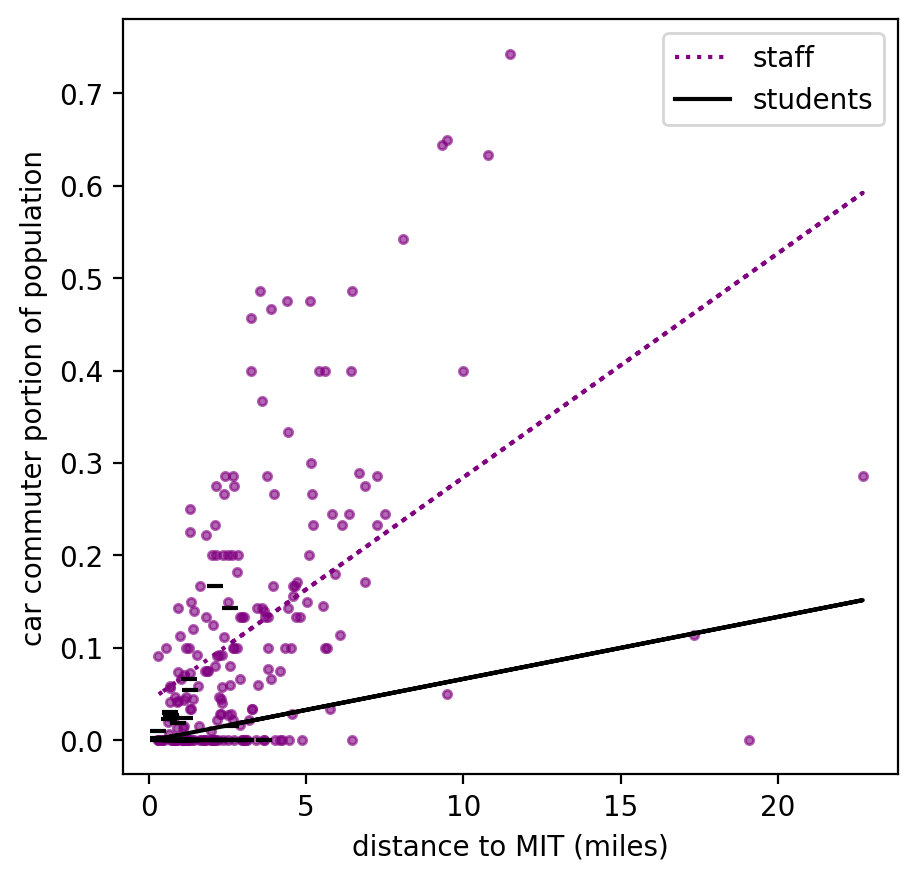

In [933]:
fig, ax = plt.subplots(1, figsize=(5,5), dpi=100)
ax.scatter(staff_x, staff_Y, marker='.', c='purple', alpha=0.6)
staff_yhat = (
    staff_model_results.params[DISTANCE_TO_MIT]*staff_x \
    + staff_model_results.params['const']
) # The line of best fit
ax.plot(staff_x, staff_yhat, 'k:', c='purple', label='staff')

ax.scatter(student_x, student_Y, marker='_', c='black', alpha=1)
student_yhat = (
    student_model_results.params[DISTANCE_TO_MIT]*staff_x \
    + student_model_results.params['const']
)  # The line of best fit
ax.plot(staff_x, student_yhat, '-', c='black', label='students')

ax.set_xlabel(DISTANCE_TO_MIT)
ax.set_ylabel('car commuter portion of population')
_ = ax.legend()